Reference coverage: 100.0%, Citation coverage: 1.7%
Edge counts: {'reference': 37, 'citation': 22, 'both': 0}


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

c:\Users\Galaxy\miniconda3\envs\litscape\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Galaxy\miniconda3\envs\litscape\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Galaxy\miniconda3\envs\litscape\Lib\site-packages\networkx\drawing\nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


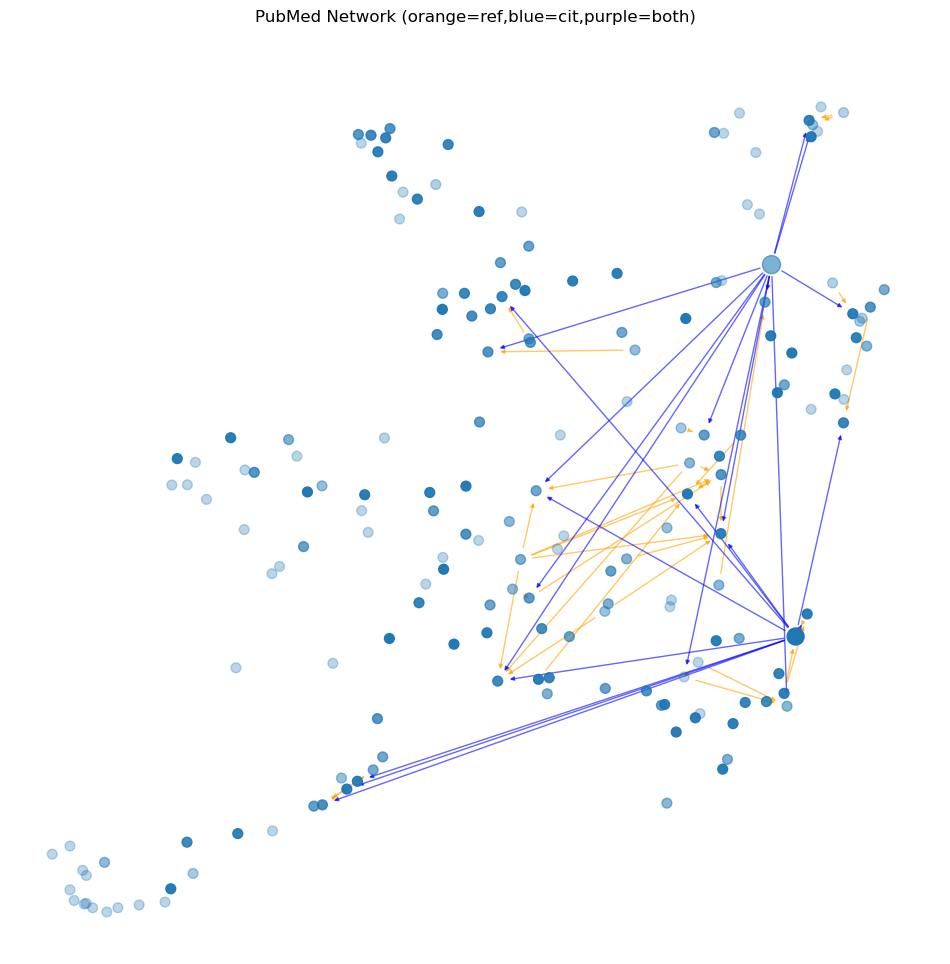

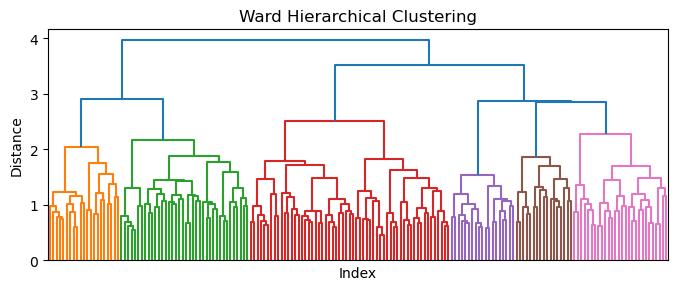

FloatSlider(value=1.1022194242368863, description='Ward T:', max=3.9613778655045873)

Output(layout=Layout(height='300px'))

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
pubmed_citation_network_full.py
Author: [Your Name]
Date: 2025-05-03

Description:
    Builds, styles, and visualizes a PubMed citation/reference network for a
    given query, with robust provenance tracking and interactive clustering.

Features:
  1. ESearch (history server) → PMIDs
  2. EFetch → title, abstract, reference lists, and EARLIEST publication date
     (ArticleDate preferred, fallback to JournalIssue/PubDate)
  3. ELink(pubmed_pubmed_citedin) in batches → citation lists
  4. Builds DiGraph:
       • Nodes carry title, abstract, date
       • Edges point cited → citing (information flow)
       • Edge attribute source_type ∈ {reference, citation, both}
       • Self-edges automatically dropped
  5. Coverage diagnostics:
       • % of all seen references present as nodes
       • % of all seen citers present as nodes
       • Edge counts by provenance
  6. Node attributes:
       • ext_citations = external citation count
       • alpha         = opacity based on age (newer → more opaque)
  7. Embeddings:
       • SBERT(all-MiniLM-L6-v2) on title+abstract (GPU if available)
       • UMAP → 2D coords for node positions
  8. Clustering:
       • DBSCAN on original embeddings → node “db_cluster”
       • Ward hierarchical clustering + dendrogram
       • ipywidgets slider to re-cut dendrogram and recolor nodes
  9. Styling:
       • Node size ∝ ext_citations
       • Node α = alpha
       • Edge color: orange=reference, blue=citation, purple=both
       • Arrows show information flow (cited → citing)
"""

import requests, time, xml.etree.ElementTree as ET
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import torch
from sentence_transformers import SentenceTransformer
from umap import UMAP
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import ipywidgets as widgets
from IPython.display import display, clear_output
import datetime

# ---------------- Configuration ---------------- #

PUBMED_QUERY = "(Enhanced recovery) AND (thoracic surgery) AND (children OR pediatric)"
MAX_RESULTS  = 1000
ELINK_BATCH  = 100

# ---------------- PubMed Utilities ---------------- #

def search_pubmed(query, retmax=MAX_RESULTS):
    """ESearch with history server → (pmids, WebEnv, QueryKey)."""
    resp = requests.get(
        "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi",
        params={"db":"pubmed","term":query,"retmax":retmax,"usehistory":"y"}
    )
    resp.raise_for_status()
    root = ET.fromstring(resp.content)
    pmids = [n.text for n in root.findall(".//IdList/Id")]
    return pmids, root.findtext(".//WebEnv"), root.findtext(".//QueryKey")

def fetch_details(pmids, webenv, qkey):
    """
    EFetch → list of dicts with
      pmid, title, abstract, refs (all in-set, no self-refs), date.
    """
    resp = requests.post(
        "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi",
        data={"db":"pubmed","retmode":"xml",
              "WebEnv":webenv,"query_key":qkey,"retmax":len(pmids)}
    )
    resp.raise_for_status()
    root = ET.fromstring(resp.content)
    MONTH = {m:i for i,m in enumerate(
        ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],1)}
    arts = []
    for art in root.findall(".//PubmedArticle"):
        pmid = art.findtext(".//PMID")
        title = art.findtext(".//ArticleTitle") or ""
        abstract = " ".join(n.text for n in art.findall(".//AbstractText") if n.text) or ""
        # parse earliest date
        date = None
        for ad in art.findall(".//ArticleDate"):
            if ad.get("DateType","").lower() in ("electronic","pubmed"):
                y,mo,dy = ad.findtext("Year"),ad.findtext("Month"),ad.findtext("Day")
                if y and y.isdigit():
                    date = datetime.date(int(y),
                        int(mo) if mo and mo.isdigit() else MONTH.get(mo[:3],1),
                        int(dy) if dy and dy.isdigit() else 1)
                    break
        if date is None:
            pj = art.find(".//JournalIssue/PubDate")
            y,mo,dy = pj.findtext("Year"),pj.findtext("Month"),pj.findtext("Day")
            if y and y.isdigit():
                date = datetime.date(int(y),
                    MONTH.get(mo[:3],1) if mo else 1,
                    int(dy) if dy and dy.isdigit() else 1)
        # references (in-set & no self)
        refs = []
        for r in art.findall(".//ReferenceList/Reference"):
            pid = r.findtext(".//ArticleId[@IdType='pubmed']")
            if pid and pid in pmids and pid!=pmid:
                refs.append(pid)
        arts.append({"pmid":pmid,"title":title,
                     "abstract":abstract,"refs":refs,"date":date})
    return arts

def fetch_citations(pmids, batch_size=ELINK_BATCH):
    """
    ELink(pubmed_pubmed_citedin) in batches → (citations_within, all_citers).
    citations_within: only those in pmids. all_citers: full set.
    """
    url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi"
    cit_within = {p:[] for p in pmids}
    all_citers  = set()
    for i in range(0,len(pmids),batch_size):
        batch = pmids[i:i+batch_size]
        resp = requests.get(url, params={
            "dbfrom":"pubmed",
            "linkname":"pubmed_pubmed_citedin",
            "id":",".join(batch)
        })
        resp.raise_for_status()
        root = ET.fromstring(resp.content)
        for ls in root.findall(".//LinkSet"):
            src = ls.findtext(".//IdList/Id")
            for tgt in ls.findall(".//LinkSetDb/Link/Id"):
                all_citers.add(tgt.text)
                if tgt.text in pmids and tgt.text!=src:
                    cit_within[src].append(tgt.text)
        time.sleep(0.34)
    return cit_within, all_citers

# ---------------- Graph Construction ---------------- #

def build_graph(arts, cit_within):
    """
    Build DiGraph:
      • Nodes carry title, abstract, date.
      • Edges point cited→citing.
      • Edge attr source_type ∈ {reference,citation,both}.
    """
    G = nx.DiGraph()
    all_refs = set()
    # add nodes
    for a in arts:
        G.add_node(a["pmid"],
                   title=a["title"],
                   abstract=a["abstract"],
                   date=a["date"])
    # reference edges
    for a in arts:
        tgt = a["pmid"]
        for ref in a["refs"]:
            all_refs.add(ref)
            if G.has_edge(ref,tgt):
                G[ref][tgt]["source_type"]="both"
            else:
                G.add_edge(ref,tgt,source_type="reference")
    # citation edges
    for src,clist in cit_within.items():
        for citer in clist:
            if G.has_edge(src,citer):
                G[src][citer]["source_type"]="both"
            else:
                G.add_edge(src,citer,source_type="citation")
    return G, all_refs

def coverage(G, all_refs, all_citers):
    """Return ref_coverage, cit_coverage, edge_type_counts."""
    nodes = set(G.nodes)
    rcov = len(all_refs & nodes)/max(1,len(all_refs))
    ccov = len(all_citers & nodes)/max(1,len(all_citers))
    cnt = {"reference":0,"citation":0,"both":0}
    for _,_,d in G.edges(data=True):
        cnt[d["source_type"]] +=1
    return rcov, ccov, cnt

# ---------------- Embedding & Clustering ---------------- #

def embed_and_project(texts):
    """SBERT→embeddings (GPU if avail) + UMAP(2D)."""
    model = SentenceTransformer("all-MiniLM-L6-v2")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device=="cuda": model=model.to("cuda")
    E = model.encode(texts,show_progress_bar=True,device=device)
    coords = UMAP(n_components=2,random_state=42).fit_transform(E)
    return E, coords

# ---------------- Main Execution ---------------- #

# 1. Fetch
pmids, we, qk             = search_pubmed(PUBMED_QUERY)
articles                 = fetch_details(pmids, we, qk)
citations_within, all_citers = fetch_citations(pmids)

# 2. Build graph + diagnostics
G, all_refs = build_graph(articles, citations_within)
rcov, ccov, ecounts = coverage(G, all_refs, all_citers)
print(f"Reference coverage: {rcov:.1%}, Citation coverage: {ccov:.1%}")
print("Edge counts:", ecounts)

# 3. Annotate nodes (ext_cits, alpha)
today = datetime.date.today()
for n in G.nodes:
    ext = len(citations_within.get(n,[]))
    G.nodes[n]['ext_cits']=ext
    d = G.nodes[n]['date']
    alpha = 0.5
    if d:
        yrs = (today-d).days/365.25
        alpha = max(0.3,min(1,1-yrs/10))
    G.nodes[n]['alpha']=alpha

# 4. Position & cluster
texts = [a["title"]+" "+a["abstract"] for a in articles]
E, coords = embed_and_project(texts)
pos = {a["pmid"]:coords[i] for i,a in enumerate(articles)}
db_labels = DBSCAN(eps=0.5,min_samples=5).fit_predict(E)
Z = linkage(E, method='ward')

# 5. Draw network
plt.figure(figsize=(12,12))
# nodes
nx.draw_networkx_nodes(G,pos,
    node_size=[50+10*G.nodes[n]['ext_cits'] for n in G],
    alpha=[G.nodes[n]['alpha'] for n in G],
    node_color=db_labels, cmap='tab20'
)
# edges
color_map = {"reference":"orange","citation":"blue","both":"purple"}
for stype,col in color_map.items():
    eds=[(u,v) for u,v,d in G.edges(data=True) if d["source_type"]==stype]
    nx.draw_networkx_edges(G,pos,edgelist=eds,edge_color=col,alpha=0.6,arrowstyle='-|>',arrowsize=6)
plt.title("PubMed Network (orange=ref,blue=cit,purple=both)")
plt.axis('off')
plt.show()

# 6. Dendrogram + interactive Ward cut
plt.figure(figsize=(8,3))
dendrogram(Z,no_labels=True)
plt.title("Ward Hierarchical Clustering")
plt.xlabel("Index"); plt.ylabel("Distance")
plt.show()

slider = widgets.FloatSlider(min=0,max=Z[:,2].max(),step=0.1,value=Z[:,2].mean(),
    description="Ward T:")
out = widgets.Output(layout={'height':'300px','overflow_y':'scroll'})
def on_val_change(change):
    with out:
        clear_output()
        labs = fcluster(Z,t=change['new'],criterion='distance')
        plt.figure(figsize=(8,8))
        nx.draw_networkx_nodes(G,pos,
            node_size=[50+10*G.nodes[n]['ext_cits'] for n in G],
            alpha=[G.nodes[n]['alpha'] for n in G],
            node_color=labs, cmap='tab20'
        )
        nx.draw_networkx_edges(G,pos,alpha=0.3)
        plt.axis('off'); plt.show()
slider.observe(on_val_change,'value')
display(slider,out)


In [32]:
# =============================================================================
# CELL: DAG Checker V14 - Simplified DOI Handling (Use EFetch DOI Directly)
# =============================================================================
# Development Notes & Issues Encountered:
#   - V1-V11: Evolution addressing ELink accuracy/reliability (POST batching),
#     EFetch speed (WebEnv), counts, interactive tables (itables), parsing fixes.
#   - V12: Confirmed POST for ELink batching works reliably.
#   - V13: Integrated CrossRef augmentation pipeline.
#     - Issue: V13.2 introduced a complex/slow separate DOI lookup using ID Converter
#       + EFetch fallback, which was unnecessary and buggy.
#     FIX (V14): Removed the separate `get_dois_for_pmids_batched` function.
#       Reverted `fetch_dates_refs...` to the version that correctly extracts the
#       DOI *along with* other details in the single EFetch call (like V13.1).
#       The augmentation step now directly uses the DOI column populated by EFetch.
#       This simplifies the code and removes the redundant/slow DOI lookup step.
#
# API Technique Testing Note: (Same as V10)
# Workflow: (Corrected)
#   1. ESearch → PMIDs, WebEnv, QueryKey. (Timed)
#   2. EFetch (Single Req) → Dates, Orig Refs, Filtered Refs, **DOI**. (Timed)
#   3. Augment References via CrossRef (for candidates with DOI & low EFetch refs). (Timed)
#      - Identify Candidates using DOI from EFetch -> Fetch CR Ref DOIs (Batched Filter) ->
#      - Batch Convert Ref DOIs to PMIDs -> Merge Refs into DataFrame
#   4. Recalculate subset_ref_count after augmentation.
#   5. ELink (Accurate POST Batch) → Orig Cit Counts & Subset Cit Lists. (Timed)
#   6. Calculate final counts, Select top SUBSET_N based on Subset Connectivity. (Timed)
#   7. Build DiGraph using subset data. Calculate graph degrees. (Timed)
#   8. Identify and remove all time‐invalid edges + Log warnings. (Timed)
#   9. Report cleaned graph size and final DAG status.
# =============================================================================

import requests
import time
import xml.etree.ElementTree as ET
import pandas as pd
import networkx as nx
import datetime
from requests.adapters import HTTPAdapter
from IPython.display import display, HTML
from itables import init_notebook_mode, show
import itables.options as opt
import traceback
import json
from urllib.parse import quote
from tqdm.notebook import tqdm
import datetime # Ensure datetime is imported

# --- itables Configuration ---
opt.interactive = True
opt.classes = ["display", "compact", "cell-border", "stripe", "hover", "table-sm"]
opt.maxBytes = 0
opt.lengthMenu = [10, 25, 50, 100, 200, -1]
init_notebook_mode(connected=True)

# --- Script Configuration ---
QUERIES        = [
    "neoplasm metastasis[mesh] AND immunotherapy[mesh]",
    "COVID-19[mesh] AND spike glycoprotein[mesh]",
    "cardiomyopathies[mesh] AND cardiac MRI[mesh]",
    "Alzheimer disease[mesh] AND neurofilament proteins[mesh]",
    "radiology[mesh] AND deep learning[tiab] AND segmentation[tiab]",
    "CRISPR-Cas systems[mesh] AND gene knockout[mesh]"
]
SEARCH_MAX     = 1000
SUBSET_N       = 200
ELINK_BATCH    = 100
NCBI_API_KEY   = "44d5c1b49a9ed02ae1fc52fa9d01e148e009" # Your key

# --- Augmentation Configuration ---
AUGMENT_REFS             = True
AUGMENT_THRESHOLD        = 5
CROSSREF_MAILTO          = "levi4328@gmail.com" # Set EMAIL
ID_CONVERTER_BATCH_SIZE  = 150
CROSSREF_FILTER_BATCH_SIZE = 50
ID_CONVERTER_FETCH_DELAY = 0.1
CROSSREF_FETCH_DELAY     = 0.1

# --- Session ---
session = requests.Session()
adapter = HTTPAdapter(pool_connections=50, pool_maxsize=50)
session.mount("https://", adapter); session.mount("http://", adapter)
session_cr = requests.Session()
adapter_cr = HTTPAdapter(pool_connections=10, pool_maxsize=10)
session_cr.mount("https://", adapter_cr)

def _get_ncbi_params(extra=None):
    """Helper for NCBI params."""
    params = {"tool": "dag_checker_v14"} # Incremented version
    if NCBI_API_KEY: params["api_key"] = NCBI_API_KEY
    if CROSSREF_MAILTO and CROSSREF_MAILTO != "YOUR_EMAIL@example.com": params["email"] = CROSSREF_MAILTO
    if extra: params.update(extra)
    return params

# --- ESearch ---
def search_pubmed(query, retmax=SEARCH_MAX):
    t0 = time.time(); print(f"1a) Searching PubMed for: '{query}' (max={retmax})")
    params = _get_ncbi_params({"db":"pubmed", "term":query, "retmax":retmax, "usehistory":"y"})
    try:
        r = session.get("https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi", params=params, timeout=30)
        r.raise_for_status(); root = ET.fromstring(r.content)
        pmids = [n.text for n in root.findall(".//IdList/Id")]
        webenv = root.findtext(".//WebEnv"); query_key = root.findtext(".//QueryKey")
        t1 = time.time(); print(f"1b) Retrieved {len(pmids)} PMIDs. WebEnv/QueryKey obtained. (Took {t1-t0:.2f}s)")
        return pmids, webenv, query_key
    except Exception as e: print(f"   - ERROR: ESearch failed: {e}"); return [], None, None

# --- EFetch (V14: Correctly gets DOI along with other details) ---
def fetch_dates_refs_dois_webenv(pmids_list, we, qk):
    """ V14: Fetches dates, refs, orig_ref_count, AND DOI using WebEnv/QueryKey. """
    t0 = time.time(); rows = []; r = None
    cols = ["pmid", "date", "refs", "orig_ref_count", "doi"]
    if not pmids_list or not we or not qk: return pd.DataFrame(columns=cols)
    print(f"2a) Fetching details+DOI for {len(pmids_list)} PMIDs using WebEnv/QueryKey...")
    params = _get_ncbi_params({"db":"pubmed", "retmode":"xml", "rettype":"abstract", "WebEnv":we, "query_key":qk, "retmax":len(pmids_list)})
    try:
        r = session.post("https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi", data=params, timeout=180)
        r.raise_for_status()
        if not r.content: print("   - WARN: EFetch empty content."); return pd.DataFrame(columns=cols)
        root = ET.fromstring(r.content); valid_pmids_set = set(pmids_list)
        MONTH = {m: i for i, m in enumerate(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"], 1)}
        processed_pmids_in_fetch = set()
        for art in root.findall(".//PubmedArticle"):
            pmid_elem = art.find(".//PMID"); pm = pmid_elem.text if pmid_elem is not None else None
            if not pm or pm not in valid_pmids_set: continue
            processed_pmids_in_fetch.add(pm)
            dt = None # Date extraction...
            for ad in art.findall(".//ArticleDate"):
                y, mo, d = ad.findtext("Year"), ad.findtext("Month"), ad.findtext("Day")
                if y and y.isdigit():
                    try: dt = datetime.date(int(y), int(mo) if mo and mo.isdigit() else MONTH.get(mo[:3], 1), int(d) if d and d.isdigit() else 1); break
                    except ValueError: dt = None
            if dt is None:
                pj = art.find(".//Journal/JournalIssue/PubDate")
                if pj is not None: y, mo, d = pj.findtext("Year"), pj.findtext("Month"), pj.findtext("Day")
                if pj and y and y.isdigit():
                    mn = MONTH.get(mo[:3], 1) if mo else 1; dn = int(d) if d and d.isdigit() else 1
                    try: dt = datetime.date(int(y), mn, dn)
                    except ValueError: dt = None
            all_refs = [r.findtext(".//ArticleId[@IdType='pubmed']") for r in art.findall(".//ReferenceList/Reference")]
            all_refs = [x for x in all_refs if x is not None]; orig_ref_count = len(all_refs)
            filtered_refs = [x for x in all_refs if x in valid_pmids_set and x != pm]
            # *** Extract DOI ***
            doi = None
            doi_elem = art.find(f".//ArticleIdList/ArticleId[@IdType='doi']")
            if doi_elem is not None and doi_elem.text: doi = doi_elem.text
            # Append row including DOI
            rows.append({"pmid": pm, "date": dt, "refs": filtered_refs, "orig_ref_count": orig_ref_count, "doi": doi})
        t1 = time.time(); print(f"2b) Successfully parsed details+DOI for {len(rows)} articles from single EFetch. (Took {t1-t0:.2f}s)")
        found_pmids_set = set(p['pmid'] for p in rows); missing_pmids = valid_pmids_set - found_pmids_set
        if missing_pmids: print(f"   - WARN: EFetch didn't return details for {len(missing_pmids)} requested PMIDs.")
        return pd.DataFrame(rows)
    except Exception as e: print(f"   - ERROR during EFetch: {e}"); return pd.DataFrame(columns=cols)


# --- CrossRef Augmentation Functions ---
def get_crossref_refs_via_filter_batch(doi_list):
    """ Queries CrossRef /works using filter=doi:A,doi:B,... in batches. """
    # ... (No changes needed from V13.1) ...
    if not doi_list: return {}, "No DOIs Provided"
    print(f"   Querying CrossRef using filter=doi:... for {len(doi_list)} DOIs (Batch size: {CROSSREF_FILTER_BATCH_SIZE})...")
    t0 = time.time(); all_results = {}; status="OK"
    for i in tqdm(range(0, len(doi_list), CROSSREF_FILTER_BATCH_SIZE), desc="CrossRef Batches", leave=False):
        batch_dois = doi_list[i:i + CROSSREF_FILTER_BATCH_SIZE]; filter_value = ",".join([f"doi:{doi}" for doi in batch_dois])
        params = {"filter": filter_value, "rows": len(batch_dois), "select": "DOI,reference"}
        headers = {"User-Agent": f"dag_checker_v14 (mailto:{CROSSREF_MAILTO})"}
        if CROSSREF_MAILTO and CROSSREF_MAILTO != "YOUR_EMAIL@example.com": params["mailto"] = CROSSREF_MAILTO
        base_url = "https://api.crossref.org/works"; request_url = ""
        try:
            req = requests.Request('GET', base_url, params=params, headers=headers).prepare(); request_url = req.url
            if len(request_url) > 4000: print(f"   WARN: URL length {len(request_url)} might be too long for CR batch {i}.")
            r = session_cr.get(request_url, headers=headers, timeout=120)
            if r.status_code == 414: status = f"CR 414 batch {i}"; break
            elif r.status_code == 429: status=f"CR 429 batch {i}"; print(f"WARN: CR Rate Limit batch {i}. Sleeping..."); time.sleep(2); continue
            elif not r.ok: status = f"CR Error {r.status_code} batch {i}"; print(f"   WARN: {status}"); continue
            data = r.json(); items = data.get("message", {}).get("items", [])
            for item in items:
                doi = item.get("DOI")
                if doi:
                    matched_input_doi = next((d for d in batch_dois if d.lower() == doi.lower()), None)
                    if matched_input_doi:
                        refs = item.get("reference", []); ref_dois = [ref.get("DOI") for ref in refs if ref.get("DOI")]
                        all_results[matched_input_doi] = ref_dois
        except Exception as e: status = f"Error CR batch {i}: {e}"; print(f"   ERROR CR batch {i}: {e}")
        time.sleep(CROSSREF_FETCH_DELAY)
    t1 = time.time(); print(f"   CrossRef filter method finished. Found ref lists for {len(all_results)} DOIs. Last status: {status}. (Took {t1-t0:.2f}s)")
    return all_results

def batch_dois_to_pmids(doi_list, batch_size=100):
    """Batch-convert DOIs → PMIDs via multiple OR-joined ESearch POSTs."""
    doi_to_pmid = {}
    unique_dois = list(dict.fromkeys(doi_list))
    if not unique_dois:
        return doi_to_pmid

    print(f"   Using batched OR-ESearch for {len(unique_dois)} DOIs (Batch size: {batch_size})...")
    for i in tqdm(range(0, len(unique_dois), batch_size), desc="OR-ESearch Batches", leave=False):
        batch = unique_dois[i:i+batch_size]
        query = " OR ".join(f"{doi}[doi]" for doi in batch)
        params = _get_ncbi_params({
            "db": "pubmed",
            "term": query,
            "retmode": "json",
            "retmax": str(len(batch))
        })
        try:
            resp = session.post("https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi", data=params, timeout=60)
            resp.raise_for_status()
            idlist = resp.json().get("esearchresult", {}).get("idlist", [])
            if not idlist:
                print(f"   - WARN: Batch {i//batch_size+1} returned 0 PMIDs")
            for doi, pmid in zip(batch, idlist):
                doi_to_pmid[doi] = pmid
        except Exception as e:
            print(f"   - ERROR: Failed to convert batch {i//batch_size+1}: {e}")
        time.sleep(0.1)

    print(f"   Final DOI→PMID map: {len(doi_to_pmid)}/{len(unique_dois)} DOIs mapped.")
    return doi_to_pmid



# --- ELink (V12 - Using POST for reliability) ---
def fetch_citations(pmids_to_query):
    """ Fetches citations using accurate POST batching. """
    # ... (No changes needed from V12/V13.1) ...
    t0 = time.time()
    if not pmids_to_query: return {}, {}
    # Step number adjusted
    print(f"4a) Fetching citations for {len(pmids_to_query)} PMIDs via POST (ELink batch size={ELINK_BATCH})...")
    orig_cit_counts = {p: 0 for p in pmids_to_query}; subset_citations = {p: [] for p in pmids_to_query}
    valid_query_set = set(pmids_to_query); pmids_list = list(pmids_to_query)
    linksets_found_count = 0; total_batches = (len(pmids_list) + ELINK_BATCH - 1) // ELINK_BATCH
    sleep_time = 0.1 if NCBI_API_KEY else 0.34
    for i in range(0, len(pmids_list), ELINK_BATCH):
        batch_num = i // ELINK_BATCH + 1; batch = pmids_list[i:i + ELINK_BATCH]
        post_data = _get_ncbi_params({"dbfrom": "pubmed", "linkname": "pubmed_pubmed_citedin"})
        post_data['id'] = batch; r = None
        try:
            r = session.post("https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi", data=post_data, timeout=120)
            if r.status_code == 429: print(f"   - WARN: 429 on ELink batch {batch_num}. Sleeping..."); time.sleep(5); continue
            r.raise_for_status();
            if not r.content: continue
            root = ET.fromstring(r.content); processed_sources_in_batch = set()
            for child in root: # V11 Parsing Loop
                if child.tag == 'LinkSet':
                    ls = child; src_elem = ls.find("./IdList/Id")
                    if src_elem is None or src_elem.text is None: continue
                    src = src_elem.text
                    if src not in valid_query_set: continue
                    processed_sources_in_batch.add(src); linksets_found_count += 1
                    link_set_db = ls.find("./LinkSetDb"); all_targets = []
                    if link_set_db is not None: all_targets = [nid.text for nid in link_set_db.findall("./Link/Id") if nid.text is not None]
                    orig_cit_counts[src] = len(all_targets)
                    filtered_targets = [t for t in all_targets if t in valid_query_set and t != src]
                    if filtered_targets: subset_citations.setdefault(src, []).extend(filtered_targets)
            missing_in_response = set(batch) - processed_sources_in_batch
            if missing_in_response: print(f"   - INFO: PMIDs requested in batch {batch_num} had NO <LinkSet> (likely 0 citations): {missing_in_response}")
            time.sleep(sleep_time)
        except requests.exceptions.Timeout: print(f"   - WARN: ELink POST timeout batch {batch_num}.")
        except requests.exceptions.RequestException as e: print(f"   - WARN: ELink POST request fail batch {batch_num}: {e}")
        except ET.ParseError as e: print(f"   - WARN: ELink POST parse error batch {batch_num}: {e}")
        except Exception as e: print(f"   - WARN: ELink POST unexpected error batch {batch_num}: {e}"); print(traceback.format_exc())
    for src_id in subset_citations: subset_citations[src_id] = list(set(subset_citations[src_id]))
    t1 = time.time()
    print(f"4b) Citation fetching complete. Queried {len(pmids_to_query)} PMIDs, processed {linksets_found_count} received <LinkSet> entries. (Took {t1-t0:.2f}s)")
    return orig_cit_counts, subset_citations


# --- Analysis Routine ---
def analyze_dag_edges(query):
    print(f"\n{'='*20} Query: {query} {'='*20}"); overall_start_time = time.time()
    # 1. ESearch
    pmids, webenv, query_key = search_pubmed(query)
    if not pmids: print("   -> Skipping query."); return
    # 2. EFetch (Includes DOI now)
    df = fetch_dates_refs_dois_webenv(pmids, webenv, query_key)
    if df.empty: print("   -> Skipping query (no details)."); return
    df = df.dropna(subset=["date"]).copy()
    if df.empty: print("   -> Skipping query (no valid dates)."); return
    fetched_pmids_set = set(df["pmid"]) # PMIDs with EFetch data

    # 3. *** CrossRef Reference Augmentation Step ***
    t0_augment = time.time()
    if AUGMENT_REFS:
        print("3a) Starting Reference Augmentation via CrossRef...")
        # Identify candidates: have DOI and low EFetch ref count
        # Use the 'doi' column directly from the df populated by EFetch
        candidates = df[(df['doi'].notna()) & (df['orig_ref_count'] < AUGMENT_THRESHOLD)].copy()
        print(f"   Found {len(candidates)} candidates for augmentation (DOI present & orig_ref_count < {AUGMENT_THRESHOLD}).")

        if not candidates.empty:
            candidate_dois = candidates['doi'].unique().tolist() # Get unique DOIs directly

            # Fetch CrossRef reference DOIs using batched filter method
            doi_to_ref_dois = get_crossref_refs_via_filter_batch(candidate_dois)

            # Collect all unique target DOIs
            all_target_dois = set()
            for ref_list in doi_to_ref_dois.values(): all_target_dois.update(ref_list)
            print(f"   Collected {len(all_target_dois)} unique target reference DOIs from CrossRef.")

            # Batch convert target DOIs to PMIDs
            if all_target_dois:
                 target_doi_pmid_map = batch_dois_to_pmids(list(all_target_dois))
                 # Merge augmented refs back into the main DataFrame
                 print("   Merging augmented references into DataFrame...")
                 augmented_rows = 0
                 # Use .apply() or iterrows with direct .loc assignment
                 for index, row in candidates.iterrows(): # Iterate candidates
                     pmid = row['pmid']; doi = row['doi']
                     if not doi or doi not in doi_to_ref_dois: continue # Skip if no DOI or no CR refs found

                     cr_ref_doi_list = doi_to_ref_dois[doi]
                     if not cr_ref_doi_list: continue # Skip if CR refs list is empty

                     # Get existing refs (already filtered to fetched_pmids_set)
                     # Make sure df.loc access uses the correct index from the original df
                     original_df_index = df.index[df['pmid'] == pmid].tolist()
                     if not original_df_index: continue # Safety check
                     idx = original_df_index[0]

                     original_refs_set = set(df.loc[idx, 'refs'])
                     current_refs_set = original_refs_set.copy()
                     newly_mapped_refs = 0
                     for ref_doi in cr_ref_doi_list:
                         mapped_pmid = target_doi_pmid_map.get(ref_doi)
                         if mapped_pmid and mapped_pmid in fetched_pmids_set and mapped_pmid != pmid and mapped_pmid not in current_refs_set:
                             current_refs_set.add(mapped_pmid)
                             newly_mapped_refs += 1
                         if newly_mapped_refs > 0:
                            # assign list into single cell without length-mismatch error
                            df.at[idx, 'refs'] = list(current_refs_set)
                            augmented_rows += 1

                 print(f"   Augmented reference lists for {augmented_rows} PMIDs.")
            else: print("   No target DOIs collected from CrossRef to convert.")
        else: print("   No candidates for augmentation found.")
        t1_augment = time.time(); print(f"3b) Reference Augmentation finished. (Took {t1_augment-t0_augment:.2f}s)")
    else: print("3) Reference Augmentation skipped by configuration.")

    # 4. Recalculate subset ref count AFTER potential augmentation
    t0_recount = time.time()
    df['refs'] = df['refs'].apply(lambda x: x if isinstance(x, list) else []) # Ensure list type
    df["subset_ref_count"] = df["refs"].apply(lambda refs: len([r for r in refs if r in fetched_pmids_set]))
    t1_recount = time.time(); print(f"4) Recalculated subset ref counts. (Took {t1_recount-t0_recount:.2f}s)")

    # 5. ELink (Fetch Citations)
    orig_cit_counts, subset_cit_dict = fetch_citations(list(fetched_pmids_set))

    # 6. Calculate final counts & Select Subset
    t0_subset = time.time()
    df["orig_cit_count"] = df["pmid"].map(orig_cit_counts).fillna(0).astype(int)
    df["subset_cit_count"] = df["pmid"].apply(lambda p: len(subset_cit_dict.get(p, [])))
    df["total_subset_conn"] = df["subset_ref_count"] + df["subset_cit_count"]
    df_top = df.nlargest(min(SUBSET_N, len(df)), "total_subset_conn").copy().reset_index(drop=True)
    subset_pmids_set_graph = set(df_top['pmid'])
    t1_subset = time.time()
    print(f"6) Final counts calculated & subset selected: Top {len(df_top)}. (Took {t1_subset-t0_subset:.2f}s)")
    display_cols = ["pmid", "date", "orig_ref_count", "orig_cit_count", "subset_ref_count", "subset_cit_count", "total_subset_conn"]

    # 7. Build Graph & Calculate Degrees
    t0_graph = time.time()
    G = nx.DiGraph(); pmid_to_date = df_top.set_index('pmid')['date'].to_dict()
    for pmid, date in pmid_to_date.items(): G.add_node(pmid, date=date)
    print(f"7a) Building graph for {G.number_of_nodes()} nodes...")
    for index, row in df_top.iterrows():
        target_node_A = row['pmid']
        current_refs = row['refs'] if isinstance(row['refs'], list) else [] # Ensure list
        for source_node_B in current_refs:
            if source_node_B in subset_pmids_set_graph: G.add_edge(source_node_B, target_node_A, provenance='reference')
        source_node_C = row['pmid']
        if source_node_C in subset_cit_dict:
            for target_node_D in subset_cit_dict[source_node_C]:
                 if target_node_D in subset_pmids_set_graph: G.add_edge(source_node_C, target_node_D, provenance='citation')
    # Assign 'both' provenance...
    edges_to_update = []; updated_provenance_count = 0
    for u, v, data in G.edges(data=True):
         if G.has_edge(v, u):
             provenance_uv = data.get('provenance'); provenance_vu = G[v][u].get('provenance')
             if (provenance_uv == 'reference' and provenance_vu == 'citation') or \
                (provenance_uv == 'citation' and provenance_vu == 'reference'):
                 if data.get('provenance') != 'both': edges_to_update.append((u, v))
                 if G[v][u].get('provenance') != 'both': edges_to_update.append((v, u))
    for u, v in set(edges_to_update):
        if G.has_edge(u,v): G[u][v]['provenance'] = 'both'; updated_provenance_count += 1
    # Calculate degrees
    in_degrees = {n: d for n, d in G.in_degree(subset_pmids_set_graph)}
    out_degrees = {n: d for n, d in G.out_degree(subset_pmids_set_graph)}
    df_top["graph_in_degree"] = df_top["pmid"].map(in_degrees).fillna(0).astype(int)
    df_top["graph_out_degree"] = df_top["pmid"].map(out_degrees).fillna(0).astype(int)
    t1_graph = time.time()
    print(f"7b) Graph built & degrees calculated. Marked {updated_provenance_count} edges as 'both'. Initial graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges. (Took {t1_graph-t0_graph:.2f}s)")

    # Display main results table
    display_cols.extend(["graph_in_degree", "graph_out_degree"])
    print("   Displaying interactive subset results grid (itables):")
    display_df = df_top[display_cols].sort_values("orig_cit_count", ascending=False)
    display(display_df)

    # 8. Identify/Remove Time-Invalid Edges & Log Warnings
    t0_viol = time.time(); violations = []
    for u, v, data in G.edges(data=True):
        date_u, date_v = G.nodes[u].get('date'), G.nodes[v].get('date')
        if date_u and date_v and date_u > date_v: violations.append({"source": u, "src_date": date_u, "target": v, "tgt_date": date_v, "provenance": data.get("provenance", "unknown")})
    num_violations = len(violations); num_edges = G.number_of_edges(); violation_percentage = (num_violations / num_edges * 100) if num_edges > 0 else 0
    if violations:
        df_viol = pd.DataFrame(violations); print(f"8) Found {num_violations} time‐invalid edges ({violation_percentage:.1f}% of initial graph edges):")
        if violation_percentage > 10.0: print(f"   *** WARNING: High percentage ({violation_percentage:.1f}%) of edges are chronologically invalid. ***")
        source_viol_counts = df_viol['source'].value_counts().to_dict()
        for node, viol_count in source_viol_counts.items():
             if node in G:
                 node_out_degree = G.out_degree(node); node_viol_perc = (viol_count / node_out_degree * 100) if node_out_degree > 0 else 0
                 if node_viol_perc > 50.0: print(f"   --- WARNING: Node {node} has {viol_count}/{node_out_degree} ({node_viol_perc:.0f}%) outgoing edges flagged as time-invalid. ---")
        print("   Displaying interactive violations grid (itables):"); display(df_viol)
        edges_to_remove = list(zip(df_viol['source'], df_viol['target']))
        removed_count = 0
        for u, v in set(edges_to_remove):
            if G.has_edge(u, v): G.remove_edge(u, v); removed_count += 1
        print(f"9) Removed {removed_count} invalid edges")
    else: print("8) No time‐invalid edges detected"); print("9) No edges removed.")
    t1_viol = time.time(); print(f"   (Violation check, logging & removal took {t1_viol-t0_viol:.2f}s)")

    # 10 & 11. Final DAG check
    is_dag = nx.is_directed_acyclic_graph(G); final_edge_count = G.number_of_edges()
    print(f"10) Cleaned graph: {G.number_of_nodes()} nodes, {final_edge_count} edges.")
    print(f"11) Final DAG status: {'✅ DAG' if is_dag else '❌ Cycles Remain'}")
    if not is_dag:
        try: cycles = list(nx.simple_cycles(G)); print(f"   - Found {len(cycles)} cycle(s). Example cycle: {cycles[0]}")
        except Exception as e: print(f"   - Could not determine cycles: {e}")
    overall_end_time = time.time()
    print(f"--- Query '{query}' finished in {overall_end_time - overall_start_time:.2f} seconds ---")
    print("-" * 60)

# --- Execute all queries ---
if __name__ == "__main__":
    elink_sleep_time = 0.1 if NCBI_API_KEY else 0.34
    print(f"Using ELink sleep time: {elink_sleep_time}s between batches.")
    if AUGMENT_REFS and (not CROSSREF_MAILTO or CROSSREF_MAILTO == "YOUR_EMAIL@example.com"):
         print("\n*** WARNING: Reference Augmentation is enabled, but CROSSREF_MAILTO is not set. Please provide your email for CrossRef's politeness policy. ***\n")
    for q in QUERIES:
        analyze_dag_edges(q)
    print("\nAnalysis complete for all queries.")

# --- Required libraries ---
# pip install requests pandas networkx lxml openpyxl itables python-dateutil tqdm

Using ELink sleep time: 0.1s between batches.

==================== Query: neoplasm metastasis[mesh] AND immunotherapy[mesh] ====================
1a) Searching PubMed for: 'neoplasm metastasis[mesh] AND immunotherapy[mesh]' (max=1000)
1b) Retrieved 1000 PMIDs. WebEnv/QueryKey obtained. (Took 0.67s)
2a) Fetching details+DOI for 1000 PMIDs using WebEnv/QueryKey...
2b) Successfully parsed details+DOI for 1000 articles from single EFetch. (Took 8.99s)
3a) Starting Reference Augmentation via CrossRef...
   Found 446 candidates for augmentation (DOI present & orig_ref_count < 5).
   Querying CrossRef using filter=doi:... for 446 DOIs (Batch size: 50)...


CrossRef Batches:   0%|          | 0/9 [00:00<?, ?it/s]

   CrossRef filter method finished. Found ref lists for 437 DOIs. Last status: OK. (Took 14.39s)
   Collected 16173 unique target reference DOIs from CrossRef.
   Using batched OR-ESearch for 16173 DOIs (Batch size: 100)...


OR-ESearch Batches:   0%|          | 0/162 [00:00<?, ?it/s]

   - WARN: Batch 17 returned 0 PMIDs
   - WARN: Batch 34 returned 0 PMIDs
   - WARN: Batch 46 returned 0 PMIDs
   - WARN: Batch 134 returned 0 PMIDs
   - WARN: Batch 146 returned 0 PMIDs
   - WARN: Batch 149 returned 0 PMIDs
   Final DOI→PMID map: 3169/16173 DOIs mapped.
   Merging augmented references into DataFrame...
   Augmented reference lists for 1492 PMIDs.
3b) Reference Augmentation finished. (Took 134.88s)
4) Recalculated subset ref counts. (Took 0.00s)
4a) Fetching citations for 998 PMIDs via POST (ELink batch size=100)...
4b) Citation fetching complete. Queried 998 PMIDs, processed 998 received <LinkSet> entries. (Took 214.88s)
6) Final counts calculated & subset selected: Top 200. (Took 0.00s)
7a) Building graph for 200 nodes...
7b) Graph built & degrees calculated. Marked 0 edges as 'both'. Initial graph: 200 nodes, 200 edges. (Took 0.01s)
   Displaying interactive subset results grid (itables):


pmid        date  orig_ref_count  orig_cit_count  subset_ref_count  \
2    29443960  2018-02-14              32            2780                 0   
7    29686425  2018-04-23             111            2743                 0   
3    29863955  2018-06-04               0            1846                 0   
8    31942075  2020-01-15              60            1278                 0   
31   28678784  2017-07-05              42            1218                 0   
..        ...         ...             ...             ...               ...   
113  39883530  2025-01-30              36               0                 1   
115  39865939  2025-01-26               0               0                 1   
116  39850897  2025-01-09             266               0                 1   
118  39740863  2025-01-01             109               0                 1   
139  38348039  2024-01-29              39               0                 1   

     subset_cit_count  total_subset_conn  graph_in_degree  graph_out_degree  
2                  11                 11                0                11  
7                   8                  8                0                 8  
3                   9                  9                0                 8  
8                   7                  7                0                 7  
31                  4                  4                0                 4  
..                ...                ...              ...               ...  
113                 0                  1                1                 0  
115                 0                  1                0                 0  
116                 0                  1                1                 0  
118                 0                  1                1                 0  
139                 0                  1                1                 0  

[200 rows x 9 columns]

8) No time‐invalid edges detected
9) No edges removed.
   (Violation check, logging & removal took 0.00s)
10) Cleaned graph: 200 nodes, 200 edges.
11) Final DAG status: ✅ DAG
--- Query 'neoplasm metastasis[mesh] AND immunotherapy[mesh]' finished in 359.48 seconds ---
------------------------------------------------------------

==================== Query: COVID-19[mesh] AND spike glycoprotein[mesh] ====================
1a) Searching PubMed for: 'COVID-19[mesh] AND spike glycoprotein[mesh]' (max=1000)
1b) Retrieved 608 PMIDs. WebEnv/QueryKey obtained. (Took 0.33s)
2a) Fetching details+DOI for 608 PMIDs using WebEnv/QueryKey...
2b) Successfully parsed details+DOI for 608 articles from single EFetch. (Took 8.25s)
3a) Starting Reference Augmentation via CrossRef...
   Found 79 candidates for augmentation (DOI present & orig_ref_count < 5).
   Querying CrossRef using filter=doi:... for 79 DOIs (Batch size: 50)...


CrossRef Batches:   0%|          | 0/2 [00:00<?, ?it/s]

   CrossRef filter method finished. Found ref lists for 76 DOIs. Last status: OK. (Took 1.85s)
   Collected 2830 unique target reference DOIs from CrossRef.
   Using batched OR-ESearch for 2830 DOIs (Batch size: 100)...


OR-ESearch Batches:   0%|          | 0/29 [00:00<?, ?it/s]

   - WARN: Batch 5 returned 0 PMIDs
   - WARN: Batch 6 returned 0 PMIDs
   - WARN: Batch 25 returned 0 PMIDs
   Final DOI→PMID map: 983/2830 DOIs mapped.
   Merging augmented references into DataFrame...
   Augmented reference lists for 541 PMIDs.
3b) Reference Augmentation finished. (Took 20.69s)
4) Recalculated subset ref counts. (Took 0.00s)
4a) Fetching citations for 608 PMIDs via POST (ELink batch size=100)...
4b) Citation fetching complete. Queried 608 PMIDs, processed 608 received <LinkSet> entries. (Took 109.07s)
6) Final counts calculated & subset selected: Top 200. (Took 0.01s)
7a) Building graph for 200 nodes...
7b) Graph built & degrees calculated. Marked 4 edges as 'both'. Initial graph: 200 nodes, 248 edges. (Took 0.01s)
   Displaying interactive subset results grid (itables):


pmid        date  orig_ref_count  orig_cit_count  subset_ref_count  \
0    33277466  2020-12-04              45             779                 1   
8    32207377  2020-12-01              27             462                 0   
44   35798890  2022-07-07              87             341                 0   
127  33053430  2020-10-11              64             272                 0   
20   32307653  2020-06-01              42             248                 0   
..        ...         ...             ...             ...               ...   
151  38433722  2024-03-01               0               0                 1   
150  38452125  2024-03-07              56               0                 1   
149  38453000  2024-03-05              30               0                 1   
176  36635906  2023-01-01               0               0                 1   
173  36736722  2023-02-02              34               0                 1   

     subset_cit_count  total_subset_conn  graph_in_degree  graph_out_degree  
0                  21                 22                1                19  
8                   7                  7                0                 6  
44                  4                  4                0                 3  
127                 2                  2                0                 1  
20                  6                  6                0                 6  
..                ...                ...              ...               ...  
151                 0                  1                0                 0  
150                 0                  1                1                 0  
149                 0                  1                1                 0  
176                 0                  1                1                 0  
173                 0                  1                0                 0  

[200 rows x 9 columns]

8) Found 12 time‐invalid edges (4.8% of initial graph edges):
   --- WARNING: Node 33741941 has 2/3 (67%) outgoing edges flagged as time-invalid. ---
   --- WARNING: Node 35792746 has 1/1 (100%) outgoing edges flagged as time-invalid. ---
   --- WARNING: Node 35988543 has 1/1 (100%) outgoing edges flagged as time-invalid. ---
   Displaying interactive violations grid (itables):


source    src_date    target    tgt_date provenance
0   33277466  2020-12-04  32936048  2020-09-16  reference
1   33277466  2020-12-04  33164751  2020-11-09  reference
2   33432067  2021-01-11  33268377  2020-12-06  reference
3   32207377  2020-12-01  32801356  2020-08-17  reference
4   36669646  2023-01-18  36334191  2022-11-05  reference
5   35931021  2022-07-14  35013235  2022-01-10       both
6   34807265  2021-12-22  34863742  2021-12-01  reference
7   35143839  2022-02-07  34869067  2021-11-18   citation
8   33741941  2021-03-19  33268377  2020-12-06   citation
9   33741941  2021-03-19  33239231  2020-11-12       both
10  35792746  2022-12-01  36430535  2022-11-14  reference
11  35988543  2022-08-04  35928813  2022-07-19   citation

9) Removed 12 invalid edges
   (Violation check, logging & removal took 0.01s)
10) Cleaned graph: 200 nodes, 236 edges.
11) Final DAG status: ✅ DAG
--- Query 'COVID-19[mesh] AND spike glycoprotein[mesh]' finished in 138.40 seconds ---
------------------------------------------------------------

==================== Query: cardiomyopathies[mesh] AND cardiac MRI[mesh] ====================
1a) Searching PubMed for: 'cardiomyopathies[mesh] AND cardiac MRI[mesh]' (max=1000)
1b) Retrieved 1000 PMIDs. WebEnv/QueryKey obtained. (Took 0.63s)
2a) Fetching details+DOI for 1000 PMIDs using WebEnv/QueryKey...
2b) Successfully parsed details+DOI for 1000 articles from single EFetch. (Took 6.79s)
3a) Starting Reference Augmentation via CrossRef...
   Found 521 candidates for augmentation (DOI present & orig_ref_count < 5).
   Querying CrossRef using filter=doi:... for 521 DOIs (Batch size: 50)...


CrossRef Batches:   0%|          | 0/11 [00:00<?, ?it/s]

   CrossRef filter method finished. Found ref lists for 508 DOIs. Last status: OK. (Took 15.72s)
   Collected 9379 unique target reference DOIs from CrossRef.
   Using batched OR-ESearch for 9379 DOIs (Batch size: 100)...


OR-ESearch Batches:   0%|          | 0/94 [00:00<?, ?it/s]

   - WARN: Batch 49 returned 0 PMIDs
   - WARN: Batch 55 returned 0 PMIDs
   - WARN: Batch 68 returned 0 PMIDs
   - WARN: Batch 83 returned 0 PMIDs
   - WARN: Batch 89 returned 0 PMIDs
   Final DOI→PMID map: 2585/9379 DOIs mapped.
   Merging augmented references into DataFrame...
   Augmented reference lists for 2977 PMIDs.
3b) Reference Augmentation finished. (Took 73.88s)
4) Recalculated subset ref counts. (Took 0.00s)
4a) Fetching citations for 999 PMIDs via POST (ELink batch size=100)...
4b) Citation fetching complete. Queried 999 PMIDs, processed 999 received <LinkSet> entries. (Took 170.66s)
6) Final counts calculated & subset selected: Top 200. (Took 0.01s)
7a) Building graph for 200 nodes...
7b) Graph built & degrees calculated. Marked 0 edges as 'both'. Initial graph: 200 nodes, 280 edges. (Took 0.01s)
   Displaying interactive subset results grid (itables):


pmid        date  orig_ref_count  orig_cit_count  subset_ref_count  \
39   34865500  2021-12-06               0             100                 0   
95   37212440  2023-05-20               0              62                 0   
17   35659266  2022-06-06             220              59                 0   
117  34656482  2021-10-13              74              57                 0   
21   35166587  2022-02-15              32              47                 0   
..        ...         ...             ...             ...               ...   
150  38057892  2023-12-07              30               0                 2   
142  38356158  2024-08-16              40               0                 2   
169  36927425  2023-01-01              86               0                 2   
186  36056155  2022-09-02              34               0                 2   
187  36043520  2022-08-31              10               0                 2   

     subset_cit_count  total_subset_conn  graph_in_degree  graph_out_degree  
39                  5                  5                0                 6  
95                  3                  3                0                 3  
17                  6                  6                0                 4  
117                 3                  3                0                 5  
21                  6                  6                0                10  
..                ...                ...              ...               ...  
150                 0                  2                1                 0  
142                 0                  2                2                 0  
169                 0                  2                1                 0  
186                 0                  2                2                 0  
187                 0                  2                2                 0  

[200 rows x 9 columns]

8) Found 13 time‐invalid edges (4.6% of initial graph edges):
   --- WARNING: Node 38288542 has 3/3 (100%) outgoing edges flagged as time-invalid. ---
   --- WARNING: Node 39012402 has 1/1 (100%) outgoing edges flagged as time-invalid. ---
   --- WARNING: Node 37950081 has 1/1 (100%) outgoing edges flagged as time-invalid. ---
   --- WARNING: Node 38736040 has 1/1 (100%) outgoing edges flagged as time-invalid. ---
   --- WARNING: Node 38492215 has 1/1 (100%) outgoing edges flagged as time-invalid. ---
   Displaying interactive violations grid (itables):


source    src_date    target    tgt_date provenance
0   36809215  2023-02-21  35622493  2022-05-27  reference
1   39012402  2024-07-16  35724800  2022-06-18  reference
2   34739045  2022-07-21  35612967  2022-05-25   citation
3   37950081  2023-11-11  35147040  2022-02-11  reference
4   35877070  2023-03-21  36809215  2023-02-21  reference
5   35877070  2023-03-21  36747201  2023-02-06   citation
6   35788758  2022-07-05  35592889  2022-01-12  reference
7   38736040  2024-05-12  35995246  2022-08-20  reference
8   38492215  2024-10-30  39143936  2024-08-15   citation
9   38288542  2024-01-29  35512952  2022-02-16  reference
10  38288542  2024-01-29  37269267  2023-05-31  reference
11  38288542  2024-01-29  37203257  2023-05-18  reference
12  35718011  2022-06-17  35147040  2022-02-11  reference

9) Removed 13 invalid edges
   (Violation check, logging & removal took 0.01s)
10) Cleaned graph: 200 nodes, 267 edges.
11) Final DAG status: ✅ DAG
--- Query 'cardiomyopathies[mesh] AND cardiac MRI[mesh]' finished in 252.02 seconds ---
------------------------------------------------------------

==================== Query: Alzheimer disease[mesh] AND neurofilament proteins[mesh] ====================
1a) Searching PubMed for: 'Alzheimer disease[mesh] AND neurofilament proteins[mesh]' (max=1000)
1b) Retrieved 530 PMIDs. WebEnv/QueryKey obtained. (Took 0.37s)
2a) Fetching details+DOI for 530 PMIDs using WebEnv/QueryKey...
2b) Successfully parsed details+DOI for 530 articles from single EFetch. (Took 9.90s)
3a) Starting Reference Augmentation via CrossRef...
   Found 249 candidates for augmentation (DOI present & orig_ref_count < 5).
   Querying CrossRef using filter=doi:... for 249 DOIs (Batch size: 50)...


CrossRef Batches:   0%|          | 0/5 [00:00<?, ?it/s]

   CrossRef filter method finished. Found ref lists for 249 DOIs. Last status: OK. (Took 5.08s)
   Collected 5678 unique target reference DOIs from CrossRef.
   Using batched OR-ESearch for 5678 DOIs (Batch size: 100)...


OR-ESearch Batches:   0%|          | 0/57 [00:00<?, ?it/s]

   - WARN: Batch 10 returned 0 PMIDs
   - WARN: Batch 17 returned 0 PMIDs
   - WARN: Batch 20 returned 0 PMIDs
   - WARN: Batch 28 returned 0 PMIDs
   - WARN: Batch 31 returned 0 PMIDs
   - WARN: Batch 41 returned 0 PMIDs
   - WARN: Batch 53 returned 0 PMIDs
   Final DOI→PMID map: 253/5678 DOIs mapped.
   Merging augmented references into DataFrame...
   Augmented reference lists for 386 PMIDs.
3b) Reference Augmentation finished. (Took 50.15s)
4) Recalculated subset ref counts. (Took 0.00s)
4a) Fetching citations for 529 PMIDs via POST (ELink batch size=100)...
4b) Citation fetching complete. Queried 529 PMIDs, processed 529 received <LinkSet> entries. (Took 244.26s)
6) Final counts calculated & subset selected: Top 200. (Took 0.01s)
7a) Building graph for 200 nodes...
7b) Graph built & degrees calculated. Marked 0 edges as 'both'. Initial graph: 200 nodes, 748 edges. (Took 0.01s)
   Displaying interactive subset results grid (itables):


pmid        date  orig_ref_count  orig_cit_count  subset_ref_count  \
0    28346578  2017-05-01              27             462                 3   
1    30664784  2019-01-21              44             440                 3   
26   32123386  2020-03-02              69             374                 3   
2    31009028  2019-07-01              24             336                 1   
3    26524180  2016-01-01              31             251                 4   
..        ...         ...             ...             ...               ...   
187  39820401  2025-03-12              45               0                 2   
185  39825484  2025-01-17              63               0                 2   
186  39825066  2025-01-18              58               0                 2   
184  39935410  2025-02-01              67               0                 2   
196  38760423  2024-05-17              37               0                 2   

     subset_cit_count  total_subset_conn  graph_in_degree  graph_out_degree  
0                  64                 67                3                64  
1                  42                 45                3                40  
26                 11                 14                3                14  
2                  38                 39                1                38  
3                  35                 39                4                33  
..                ...                ...              ...               ...  
187                 0                  2                2                 0  
185                 0                  2                2                 0  
186                 0                  2                1                 0  
184                 0                  2                2                 0  
196                 0                  2                2                 0  

[200 rows x 9 columns]

8) Found 1 time‐invalid edges (0.1% of initial graph edges):
   --- WARNING: Node 31029057 has 1/1 (100%) outgoing edges flagged as time-invalid. ---
   Displaying interactive violations grid (itables):


source    src_date    target    tgt_date provenance
0  31029057  2019-04-27  10822437  2000-05-23  reference

9) Removed 1 invalid edges
   (Violation check, logging & removal took 0.01s)
10) Cleaned graph: 200 nodes, 747 edges.
11) Final DAG status: ✅ DAG
--- Query 'Alzheimer disease[mesh] AND neurofilament proteins[mesh]' finished in 304.74 seconds ---
------------------------------------------------------------

==================== Query: radiology[mesh] AND deep learning[tiab] AND segmentation[tiab] ====================
1a) Searching PubMed for: 'radiology[mesh] AND deep learning[tiab] AND segmentation[tiab]' (max=1000)
1b) Retrieved 1000 PMIDs. WebEnv/QueryKey obtained. (Took 0.40s)
2a) Fetching details+DOI for 1000 PMIDs using WebEnv/QueryKey...
2b) Successfully parsed details+DOI for 1000 articles from single EFetch. (Took 9.29s)
3a) Starting Reference Augmentation via CrossRef...
   Found 474 candidates for augmentation (DOI present & orig_ref_count < 5).
   Querying CrossRef using filter=doi:... for 474 DOIs (Batch size: 50)...


CrossRef Batches:   0%|          | 0/10 [00:00<?, ?it/s]

   CrossRef filter method finished. Found ref lists for 469 DOIs. Last status: OK. (Took 13.90s)
   Collected 11634 unique target reference DOIs from CrossRef.
   Using batched OR-ESearch for 11634 DOIs (Batch size: 100)...


OR-ESearch Batches:   0%|          | 0/117 [00:00<?, ?it/s]

   - WARN: Batch 86 returned 0 PMIDs
   - WARN: Batch 100 returned 0 PMIDs
   - WARN: Batch 104 returned 0 PMIDs
   Final DOI→PMID map: 6382/11634 DOIs mapped.
   Merging augmented references into DataFrame...
   Augmented reference lists for 1645 PMIDs.
3b) Reference Augmentation finished. (Took 105.63s)
4) Recalculated subset ref counts. (Took 0.00s)
4a) Fetching citations for 1000 PMIDs via POST (ELink batch size=100)...
4b) Citation fetching complete. Queried 1000 PMIDs, processed 1000 received <LinkSet> entries. (Took 171.09s)
6) Final counts calculated & subset selected: Top 200. (Took 0.01s)
7a) Building graph for 200 nodes...
7b) Graph built & degrees calculated. Marked 0 edges as 'both'. Initial graph: 200 nodes, 134 edges. (Took 0.01s)
   Displaying interactive subset results grid (itables):


pmid        date  orig_ref_count  orig_cit_count  subset_ref_count  \
8    36803407  2023-01-31               0              19                 2   
24   36870441  2023-03-02               0              18                 0   
67   37402784  2023-07-04              30              14                 0   
21   37316638  2023-06-14              12              12                 0   
70   37148371  2023-05-06              16              12                 0   
..        ...         ...             ...             ...               ...   
172  38657562  2024-04-09               0               0                 1   
191  38319676  2024-02-06              36               0                 1   
189  38323835  2024-02-07               0               0                 1   
185  38378834  2024-02-21              20               0                 1   
186  38340573  2024-02-09               0               0                 1   

     subset_cit_count  total_subset_conn  graph_in_degree  graph_out_degree  
8                   2                  4                2                 2  
24                  3                  3                0                 4  
67                  2                  2                0                 2  
21                  3                  3                0                 3  
70                  2                  2                0                 3  
..                ...                ...              ...               ...  
172                 0                  1                1                 0  
191                 0                  1                0                 0  
189                 0                  1                0                 0  
185                 0                  1                1                 0  
186                 0                  1                0                 0  

[200 rows x 9 columns]

8) Found 8 time‐invalid edges (6.0% of initial graph edges):
   --- WARNING: Node 39192505 has 5/6 (83%) outgoing edges flagged as time-invalid. ---
   --- WARNING: Node 39138806 has 1/1 (100%) outgoing edges flagged as time-invalid. ---
   Displaying interactive violations grid (itables):


source    src_date    target    tgt_date provenance
0  36788735  2023-02-25  36803407  2023-01-31  reference
1  39138806  2024-08-13  38667630  2024-04-26  reference
2  38878813  2024-06-13  36899506  2022-11-04  reference
3  39192505  2024-10-01  36803407  2023-01-31  reference
4  39192505  2024-10-01  38878632  2024-06-02  reference
5  39192505  2024-10-01  38477634  2024-03-13  reference
6  39192505  2024-10-01  38325548  2024-02-06  reference
7  39192505  2024-10-01  38271792  2024-01-18  reference

9) Removed 8 invalid edges
   (Violation check, logging & removal took 0.01s)
10) Cleaned graph: 200 nodes, 126 edges.
11) Final DAG status: ✅ DAG
--- Query 'radiology[mesh] AND deep learning[tiab] AND segmentation[tiab]' finished in 286.47 seconds ---
------------------------------------------------------------

==================== Query: CRISPR-Cas systems[mesh] AND gene knockout[mesh] ====================
1a) Searching PubMed for: 'CRISPR-Cas systems[mesh] AND gene knockout[mesh]' (max=1000)
1b) Retrieved 1000 PMIDs. WebEnv/QueryKey obtained. (Took 0.38s)
2a) Fetching details+DOI for 1000 PMIDs using WebEnv/QueryKey...
2b) Successfully parsed details+DOI for 1000 articles from single EFetch. (Took 7.89s)
3a) Starting Reference Augmentation via CrossRef...
   Found 357 candidates for augmentation (DOI present & orig_ref_count < 5).
   Querying CrossRef using filter=doi:... for 357 DOIs (Batch size: 50)...


CrossRef Batches:   0%|          | 0/8 [00:00<?, ?it/s]

   CrossRef filter method finished. Found ref lists for 347 DOIs. Last status: OK. (Took 20.96s)
   Collected 10967 unique target reference DOIs from CrossRef.
   Using batched OR-ESearch for 10967 DOIs (Batch size: 100)...


OR-ESearch Batches:   0%|          | 0/110 [00:00<?, ?it/s]

   - WARN: Batch 19 returned 0 PMIDs
   - WARN: Batch 50 returned 0 PMIDs
   Final DOI→PMID map: 2896/10967 DOIs mapped.
   Merging augmented references into DataFrame...
   Augmented reference lists for 590 PMIDs.
3b) Reference Augmentation finished. (Took 103.78s)
4) Recalculated subset ref counts. (Took 0.00s)
4a) Fetching citations for 999 PMIDs via POST (ELink batch size=100)...
4b) Citation fetching complete. Queried 999 PMIDs, processed 999 received <LinkSet> entries. (Took 138.89s)
6) Final counts calculated & subset selected: Top 200. (Took 0.01s)
7a) Building graph for 200 nodes...
7b) Graph built & degrees calculated. Marked 0 edges as 'both'. Initial graph: 200 nodes, 139 edges. (Took 0.02s)
   Displaying interactive subset results grid (itables):


pmid        date  orig_ref_count  orig_cit_count  subset_ref_count  \
48   31511426  2019-09-11             259             296                 1   
46   31615983  2019-10-15              45             204                 0   
3    34930405  2021-12-20              34             179                 1   
191  30872531  2019-03-14              28             169                 0   
183  31040209  2019-04-30              44             157                 0   
..        ...         ...             ...             ...               ...   
91   37980693  2023-11-19              37               0                 1   
94   36995621  2023-01-01              18               0                 1   
197  40328729  2025-05-06              57               0                 0   
198  40328723  2025-04-25               0               0                 0   
199  40302337  2025-04-23               0               0                 0   

     subset_cit_count  total_subset_conn  graph_in_degree  graph_out_degree  
48                  1                  2                1                 1  
46                  2                  2                0                 2  
3                   3                  4                1                 4  
191                 1                  1                0                 1  
183                 1                  1                0                 1  
..                ...                ...              ...               ...  
91                  0                  1                1                 0  
94                  0                  1                1                 0  
197                 0                  0                0                 0  
198                 0                  0                0                 0  
199                 0                  0                0                 0  

[200 rows x 9 columns]

8) Found 7 time‐invalid edges (5.0% of initial graph edges):
   --- WARNING: Node 34135367 has 3/5 (60%) outgoing edges flagged as time-invalid. ---
   --- WARNING: Node 32522852 has 1/1 (100%) outgoing edges flagged as time-invalid. ---
   --- WARNING: Node 32029769 has 1/1 (100%) outgoing edges flagged as time-invalid. ---
   Displaying interactive violations grid (itables):


source    src_date    target    tgt_date provenance
0  32627965  2020-07-01  33054419  2020-06-01  reference
1  34135367  2021-06-16  32882392  2020-08-31  reference
2  34135367  2021-06-16  32539998  2020-03-12  reference
3  34135367  2021-06-16  32081255  2020-02-09  reference
4  32522852  2020-08-17  32781607  2020-08-06   citation
5  32029769  2020-02-06  31765708  2019-11-22  reference
6  31101849  2019-05-17  30981667  2019-04-11  reference

9) Removed 7 invalid edges
   (Violation check, logging & removal took 0.01s)
10) Cleaned graph: 200 nodes, 132 edges.
11) Final DAG status: ✅ DAG
--- Query 'CRISPR-Cas systems[mesh] AND gene knockout[mesh]' finished in 251.03 seconds ---
------------------------------------------------------------

Analysis complete for all queries.


In [ ]:
# ============================================================
# SCRIPT: elink_batch_comparison.py
# ============================================================
# Purpose:
#   - Compare three batched ELink citation‐fetch strategies:
#     1) Direct `cmd=neighbor` with all PMIDs in one POST
#     2) History‐server: EPost → ELink (`cmd=neighbor_history`) → ELink (`cmd=neighbor`)
#     3) Chunked `cmd=neighbor` in sub‐batches (e.g. 200 PMIDs each)
#   - Measure times, capture raw XML, and verify per‐PMID LinkSet counts.
# ============================================================

import requests
import time
import xml.etree.ElementTree as ET
from tqdm import tqdm

# --- Configuration ---
PMIDS = [  # replace with your ~1000‐entry list
    "33414217", "27565338", "19139763", # … up to 1000 PMIDs
]
CHUNK_SIZE = 200
TOOL   = "elink_batch_compare"
EMAIL  = "your.email@example.com"
API_KEY = None  # if you have one

def add_common_params(data):
    data.append(("tool", TOOL))
    data.append(("email", EMAIL))
    if API_KEY:
        data.append(("api_key", API_KEY))
    return data

# --- 1) Direct cmd=neighbor ---
def test_direct(pmids):
    data = [
        ("dbfrom",   "pubmed"),
        ("db",       "pubmed"),
        ("linkname", "pubmed_pubmed_citedin"),
        ("cmd",      "neighbor"),
    ] + [("id", pm) for pm in pmids]
    add_common_params(data)

    t0 = time.perf_counter()
    resp = requests.post("https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi",
                         data=data, timeout=300)
    elapsed = time.perf_counter() - t0
    resp.raise_for_status()
    raw = resp.text

    root = ET.fromstring(raw)
    linksets = root.findall(".//LinkSet")
    success = (len(linksets) == len(pmids))

    return {
        "approach":      "direct",
        "time_s":        elapsed,
        "linkset_count": len(linksets),
        "success":       success,
        "raw_sample":    raw[:1000].replace("\n", " "),
    }

# --- 2) History‐server approach ---
def test_history(pmids):
    # A) EPost
    epost_data = [
        ("db", "pubmed"),
        ("id", ",".join(pmids))
    ]
    add_common_params(epost_data)
    t0 = time.perf_counter()
    r_ep = requests.post("https://eutils.ncbi.nlm.nih.gov/entrez/eutils/epost.fcgi",
                         data=epost_data, timeout=300)
    epost_time = time.perf_counter() - t0
    r_ep.raise_for_status()
    root_ep = ET.fromstring(r_ep.content)
    WebEnv   = root_ep.findtext(".//WebEnv")
    QueryKey = root_ep.findtext(".//QueryKey")

    # B) ELink to store history (no LinkSet returned)
    hist_data = [
        ("dbfrom",    "pubmed"),
        ("db",        "pubmed"),
        ("linkname",  "pubmed_pubmed_citedin"),
        ("cmd",       "neighbor_history"),
        ("WebEnv",    WebEnv),
        ("query_key", QueryKey),
    ]
    add_common_params(hist_data)
    t1 = time.perf_counter()
    r_hist = requests.post("https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi",
                           data=hist_data, timeout=300)
    hist_time = time.perf_counter() - t1
    r_hist.raise_for_status()

    # C) ELink to fetch actual LinkSets
    link_data = [
        ("dbfrom",    "pubmed"),
        ("db",        "pubmed"),
        ("linkname",  "pubmed_pubmed_citedin"),
        ("cmd",       "neighbor"),
        ("WebEnv",    WebEnv),
        ("query_key", QueryKey),
    ]
    add_common_params(link_data)
    t2 = time.perf_counter()
    r_link = requests.post("https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi",
                           data=link_data, timeout=300)
    link_time = time.perf_counter() - t2
    r_link.raise_for_status()
    raw = r_link.text

    root = ET.fromstring(raw)
    linksets = root.findall(".//LinkSet")
    success = (len(linksets) == len(pmids))

    return {
        "approach":      "history",
        "time_epost":    epost_time,
        "time_hist":     hist_time,
        "time_link":     link_time,
        "linkset_count": len(linksets),
        "success":       success,
        "raw_sample":    raw[:1000].replace("\n", " "),
    }

# --- 3) Chunked neighbor ---
def test_chunked(pmids, chunk_size=CHUNK_SIZE):
    total_linksets = 0
    raw_samples = []
    t0 = time.perf_counter()
    for chunk in tqdm([pmids[i:i+chunk_size] for i in range(0, len(pmids), chunk_size)],
                      desc="Chunked batches"):
        data = [
            ("dbfrom",   "pubmed"),
            ("db",       "pubmed"),
            ("linkname", "pubmed_pubmed_citedin"),
            ("cmd",      "neighbor"),
        ] + [("id", pm) for pm in chunk]
        add_common_params(data)

        resp = requests.post("https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi",
                             data=data, timeout=300)
        resp.raise_for_status()
        raw = resp.text
        root = ET.fromstring(raw)
        ls = root.findall(".//LinkSet")
        total_linksets += len(ls)
        raw_samples.append(raw[:500])
    elapsed = time.perf_counter() - t0
    success = (total_linksets == len(pmids))
    return {
        "approach":      "chunked",
        "time_s":        elapsed,
        "linkset_count": total_linksets,
        "success":       success,
        "raw_samples":   raw_samples[:3],
    }

# --- Run tests ---
if __name__ == "__main__":
    tests = [test_direct, test_history, lambda p: test_chunked(p, CHUNK_SIZE)]
    for fn in tests:
        result = fn(PMIDS)
        print(f"\nApproach: {result['approach']}")
        if result['approach']=="history":
            print(f"  EPost time  : {result['time_epost']:.2f}s")
            print(f"  Hist store  : {result['time_hist']:.2f}s")
            print(f"  Fetch time  : {result['time_link']:.2f}s")
        else:
            print(f"  Total time  : {result['time_s']:.2f}s")
        print(f"  LinkSets    : {result['linkset_count']}/{len(PMIDS)}")
        print(f"  Success     : {result['success']}")
        print("  Raw sample:")
        if result['approach']=="chunked":
            for sample in result['raw_samples']:
                print("   ", sample.replace("\n"," "))
        else:
            print("   ", result['raw_sample'])



Approach: direct
  Total time  : 0.68s
  LinkSets    : 3/3
  Success     : True
  Raw sample:
    <?xml version="1.0" encoding="UTF-8" ?> <!DOCTYPE eLinkResult PUBLIC "-//NLM//DTD elink 20101123//EN" "https://eutils.ncbi.nlm.nih.gov/eutils/dtd/20101123/elink.dtd"> <eLinkResult>    <LinkSet>     <DbFrom>pubmed</DbFrom>     <IdList>       <Id>33414217</Id>     </IdList>     <LinkSetDb>       <DbTo>pubmed</DbTo>       <LinkName>pubmed_pubmed_citedin</LinkName>                <Link> 				<Id>40234385</Id> 			</Link>         <Link> 				<Id>40200559</Id> 			</Link>         <Link> 				<Id>40155380</Id> 			</Link>         <Link> 				<Id>40085705</Id> 			</Link>         <Link> 				<Id>40082433</Id> 			</Link>         <Link> 				<Id>39112472</Id> 			</Link>         <Link> 				<Id>39021088</Id> 			</Link>         <Link> 				<Id>38634115</Id> 			</Link>         <Link> 				<Id>38538584</Id> 			</Link>         <Link> 				<Id>38447081</Id> 			</Link>         <Link> 				<Id>38299118</Id> 			</Link>   

Chunked batches: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Approach: chunked
  Total time  : 0.64s
  LinkSets    : 3/3
  Success     : True
  Raw sample:
    <?xml version="1.0" encoding="UTF-8" ?> <!DOCTYPE eLinkResult PUBLIC "-//NLM//DTD elink 20101123//EN" "https://eutils.ncbi.nlm.nih.gov/eutils/dtd/20101123/elink.dtd"> <eLinkResult>    <LinkSet>     <DbFrom>pubmed</DbFrom>     <IdList>       <Id>33414217</Id>     </IdList>     <LinkSetDb>       <DbTo>pubmed</DbTo>       <LinkName>pubmed_pubmed_citedin</LinkName>                <Link> 				<Id>40234385</Id> 			</Link>         <Link> 				<Id>40200559</Id> 			</Link>         <Link> 				<Id>40155380</


In [27]:
# ============================================================
# SCRIPT: elink_load_test_v2.py
# ============================================================
# Purpose:
#   - Simulate citation fetching for 200 PMIDs using multiple ELink approaches:
#       1) Direct POST `cmd=neighbor` (XML)
#       2) Direct POST `cmd=neighbor` (JSON)
#       3) History‐server (`EPost` → `cmd=neighbor_history` + `cmd=neighbor`) (XML)
#       4) History‐server (`EPost` → `cmd=neighbor_history` + `cmd=neighbor`) (JSON)
#       5) Chunked `cmd=neighbor` in sub‐batches of 50 (XML)
#   - Measure elapsed time, verify per‐PMID LinkSet counts, and capture raw responses.
# Requirements:
#   pip install requests tqdm

import requests
import time
import xml.etree.ElementTree as ET
import json
from tqdm import tqdm

# --- Configuration ---
QUERY     = "neoplasm metastasis[mesh] AND immunotherapy[mesh]"
MAX_PMIDS = 100
TOOL      = "elink_load_test_v2"
EMAIL     = "your.email@example.com"
API_KEY   = None
CHUNK_SIZE = 50

def ncbi_common(params=None):
    p = {"tool": TOOL, "email": EMAIL}
    if API_KEY:
        p["api_key"] = API_KEY
    if params:
        p.update(params)
    return p

# 1) ESearch → PMIDs
r = requests.get(
    "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi",
    params=ncbi_common({
        "db":"pubmed", "term":QUERY,
        "retmax":str(MAX_PMIDS), "usehistory":"n"
    }),
    timeout=60
)
r.raise_for_status()
root = ET.fromstring(r.content)
PMIDS = [e.text for e in root.findall(".//IdList/Id")]
assert len(PMIDS) == MAX_PMIDS

# 2) Define fetch functions
def fetch_direct(pmids, retmode="xml"):
    data = [
        ("dbfrom","pubmed"),("db","pubmed"),
        ("linkname","pubmed_pubmed_citedin"),
        ("cmd","neighbor")
    ] + [("id", pm) for pm in pmids]
    t0 = time.perf_counter()
    resp = requests.post(
        "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi",
        params=ncbi_common({"retmode": retmode}),
        data=data,
        timeout=300
    )
    elapsed = time.perf_counter() - t0
    resp.raise_for_status()
    if retmode=="xml":
        root = ET.fromstring(resp.content)
        count = len(root.findall(".//LinkSet"))
    else:
        j = resp.json()
        # JSON structure: top-level "linksets" list
        count = len(j.get("linksets", []))
    return elapsed, count, resp.text[:500]

def fetch_history(pmids, retmode="xml"):
    # EPost
    t0 = time.perf_counter()
    epost = requests.post(
        "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/epost.fcgi",
        params=ncbi_common(),
        data=[("db","pubmed"), ("id", ",".join(pmids))],
        timeout=300
    )
    epost_time = time.perf_counter() - t0
    epost.raise_for_status()
    rc = ET.fromstring(epost.content)
    we = rc.findtext(".//WebEnv")
    qk = rc.findtext(".//QueryKey")

    # neighbor_history (stores links)
    hist = requests.post(
        "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi",
        params=ncbi_common(),
        data=[
            ("dbfrom","pubmed"),("db","pubmed"),
            ("linkname","pubmed_pubmed_citedin"),
            ("cmd","neighbor_history"),
            ("WebEnv", we), ("query_key", qk)
        ],
        timeout=300
    )
    hist.raise_for_status()

    # neighbor fetch
    t1 = time.perf_counter()
    link = requests.post(
        "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi",
        params=ncbi_common({"retmode": retmode}),
        data=[
            ("dbfrom","pubmed"),("db","pubmed"),
            ("linkname","pubmed_pubmed_citedin"),
            ("cmd","neighbor"),
            ("WebEnv", we), ("query_key", qk)
        ],
        timeout=300
    )
    link_time = time.perf_counter() - t1
    link.raise_for_status()
    if retmode=="xml":
        root = ET.fromstring(link.content)
        count = len(root.findall(".//LinkSet"))
    else:
        j = link.json()
        count = len(j.get("linksets", []))
    return epost_time, link_time, count, link.text[:500]

def fetch_chunked(pmids, chunk_size=CHUNK_SIZE):
    total_linksets = 0
    samples = []
    t0 = time.perf_counter()
    for chunk in tqdm([pmids[i:i+chunk_size] for i in range(0, len(pmids), chunk_size)],
                      desc="Chunked batches"):
        data = [
            ("dbfrom","pubmed"),("db","pubmed"),
            ("linkname","pubmed_pubmed_citedin"),
            ("cmd","neighbor")
        ] + [("id", pm) for pm in chunk]
        resp = requests.post(
            "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi",
            params=ncbi_common({"retmode":"xml"}),
            data=data,
            timeout=300
        )
        resp.raise_for_status()
        root = ET.fromstring(resp.content)
        ls = root.findall(".//LinkSet")
        total_linksets += len(ls)
        samples.append(resp.text[:200])
    elapsed = time.perf_counter() - t0
    return elapsed, total_linksets, samples[:3]

# 3) Run tests
if __name__=="__main__":
    print("Direct XML...")
    dt_xml = fetch_direct(PMIDS, "xml")
    print(f"  Time: {dt_xml[0]:.2f}s  LinkSets: {dt_xml[1]}/{len(PMIDS)}")
    print("Direct JSON...")
    dt_json = fetch_direct(PMIDS, "json")
    print(f"  Time: {dt_json[0]:.2f}s  LinkSets: {dt_json[1]}/{len(PMIDS)}")
    
    print("\nHistory XML...")
    ep, lt, cnt, sample = fetch_history(PMIDS, "xml")
    print(f"  EPost: {ep:.2f}s  ELink: {lt:.2f}s  LinkSets: {cnt}/{len(PMIDS)}")
    print("History JSON...")
    ep, lt, cnt, sample = fetch_history(PMIDS, "json")
    print(f"  EPost: {ep:.2f}s  ELink: {lt:.2f}s  LinkSets: {cnt}/{len(PMIDS)}")
    
    print("\nChunked XML (size=50)...")
    ch, cnt, sm = fetch_chunked(PMIDS, CHUNK_SIZE)
    print(f"  Time: {ch:.2f}s  LinkSets: {cnt}/{len(PMIDS)}")


Direct XML...
  Time: 11.36s  LinkSets: 100/100
Direct JSON...
  Time: 11.39s  LinkSets: 100/100

History XML...
  EPost: 0.34s  ELink: 0.34s  LinkSets: 1/100
History JSON...
  EPost: 0.35s  ELink: 0.39s  LinkSets: 1/100

Chunked XML (size=50)...


Chunked batches: 100%|██████████| 2/2 [00:16<00:00,  8.32s/it]

  Time: 16.64s  LinkSets: 100/100


In [29]:
# ============================================================
# SCRIPT: elink_get_load_test.py
# ============================================================
# Purpose:
#   - Re-run the citation‐fetch load test for 200 PMIDs using **GET** requests:
#       1) Direct GET `cmd=neighbor` (XML)
#       2) Direct GET `cmd=neighbor` (JSON)
#       3) Chunked GET `cmd=neighbor` (XML, batch size=50)
#       4) Chunked GET `cmd=neighbor` (JSON, batch size=50)
#   - Measure elapsed time, verify one <LinkSet> per PMID, and capture raw response snippets.
# Requirements:
#   pip install requests tqdm

import requests
import time
import xml.etree.ElementTree as ET
from tqdm import tqdm

# --- Configuration ---
QUERY      = "neoplasm metastasis[mesh] AND immunotherapy[mesh]"
MAX_PMIDS  = 100
TOOL       = "elink_get_load_test"
EMAIL      = "your.email@example.com"
API_KEY    = None
CHUNK_SIZE = 50

def ncbi_common(params=None):
    p = {"tool": TOOL, "email": EMAIL}
    if API_KEY:
        p["api_key"] = API_KEY
    if params:
        p.update(params)
    return p

# 1) Get 200 PMIDs via ESearch
r = requests.get(
    "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi",
    params=ncbi_common({
        "db":"pubmed","term":QUERY,
        "retmax":str(MAX_PMIDS),"usehistory":"n"
    }),
    timeout=60
)
r.raise_for_status()
root = ET.fromstring(r.content)
PMIDS = [e.text for e in root.findall(".//IdList/Id")]
assert len(PMIDS) == MAX_PMIDS

# 2) Direct GET neighbor
def get_direct(pmids, retmode="xml"):
    params = ncbi_common({
        "dbfrom":"pubmed",
        "db":"pubmed",
        "linkname":"pubmed_pubmed_citedin",
        "cmd":"neighbor",
        "retmode":retmode
    })
    # add multiple id params
    for pm in pmids:
        params.setdefault("id", []).append(pm)
    t0 = time.perf_counter()
    resp = requests.get("https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi",
                        params=params, timeout=300)
    elapsed = time.perf_counter() - t0
    resp.raise_for_status()
    if retmode=="xml":
        root = ET.fromstring(resp.content)
        count = len(root.findall(".//LinkSet"))
    else:
        j = resp.json()
        count = len(j.get("linksets", []))
    return elapsed, count, resp.text[:500]

# 3) Chunked GET neighbor
def get_chunked(pmids, retmode="xml", chunk_size=CHUNK_SIZE):
    total_count = 0
    snippets = []
    t0 = time.perf_counter()
    for chunk in tqdm([pmids[i:i+chunk_size] for i in range(0, len(pmids), chunk_size)],
                      desc="Chunked GET"):
        params = ncbi_common({
            "dbfrom":"pubmed",
            "db":"pubmed",
            "linkname":"pubmed_pubmed_citedin",
            "cmd":"neighbor",
            "retmode":retmode
        })
        for pm in chunk:
            params.setdefault("id", []).append(pm)
        resp = requests.get("https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi",
                            params=params, timeout=300)
        resp.raise_for_status()
        if retmode=="xml":
            root = ET.fromstring(resp.content)
            total_count += len(root.findall(".//LinkSet"))
        else:
            total_count += len(resp.json().get("linksets", []))
        snippets.append(resp.text[:200])
    elapsed = time.perf_counter() - t0
    return elapsed, total_count, snippets[:3]

# --- Run tests ---
if __name__ == "__main__":
    print("Direct GET XML...")
    t_xml, cnt_xml, snip_xml = get_direct(PMIDS, "xml")
    print(f"  Time: {t_xml:.2f}s  LinkSets: {cnt_xml}/{len(PMIDS)}")

    print("Direct GET JSON...")
    t_json, cnt_json, snip_json = get_direct(PMIDS, "json")
    print(f"  Time: {t_json:.2f}s  LinkSets: {cnt_json}/{len(PMIDS)}")

    print("\nChunked GET XML...")
    t_cxml, cnt_cxml, snip_cxml = get_chunked(PMIDS, "xml", CHUNK_SIZE)
    print(f"  Time: {t_cxml:.2f}s  LinkSets: {cnt_cxml}/{len(PMIDS)}")

    print("Chunked GET JSON...")
    t_cjson, cnt_cjson, snip_cjson = get_chunked(PMIDS, "json", CHUNK_SIZE)
    print(f"  Time: {t_cjson:.2f}s  LinkSets: {cnt_cjson}/{len(PMIDS)}")


Direct GET XML...
  Time: 14.57s  LinkSets: 100/100
Direct GET JSON...
  Time: 14.02s  LinkSets: 100/100

Chunked GET XML...


Chunked GET: 100%|██████████| 2/2 [00:14<00:00,  7.50s/it]


  Time: 15.00s  LinkSets: 100/100
Chunked GET JSON...


Chunked GET: 100%|██████████| 2/2 [00:17<00:00,  8.70s/it]

  Time: 17.40s  LinkSets: 100/100


In [31]:
# ============================================================
# SCRIPT: doi_to_pmid_benchmark_v2.py
# ============================================================
# Purpose:
#   - Benchmark multiple DOI→PMID mapping approaches on ~100 DOIs:
#       1) PMC ID Converter (batch up to 200 DOIs)
#       2) OR-joined ESearch via POST (batch size 100)
#       3) OR-joined ESearch via POST (batch size 50)
#       4) Per-DOI ESearch (one POST per DOI)
#       5) Europe PMC REST (one GET per DOI)
#   - Measures elapsed time, counts mappings, and reports results.
# Requirements:
#   pip install requests tqdm

import requests, time, xml.etree.ElementTree as ET
from tqdm import tqdm

# --- Configuration ---
QUERY     = "neoplasm metastasis[mesh] AND immunotherapy[mesh]"
MAX_PMIDS = 100
TOOL      = "doi_to_pmid_bench_v2"
EMAIL     = "your.email@example.com"
API_KEY   = None  # optional
EPMC_URL  = "https://www.ebi.ac.uk/europepmc/webservices/rest/search"

def ncbi_common(extra=None):
    """Common NCBI params for POST bodies."""
    p = {"tool": TOOL, "email": EMAIL}
    if API_KEY:
        p["api_key"] = API_KEY
    if extra:
        p.update(extra)
    return p

# Step 1: Collect ~100 DOIs
def collect_dois():
    # a) ESearch
    r_es = requests.post(
        "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi",
        data=ncbi_common({
            "db":"pubmed","term":QUERY,
            "retmax":str(MAX_PMIDS),"usehistory":"n"
        }),
        timeout=60
    )
    r_es.raise_for_status()
    root = ET.fromstring(r_es.content)
    pmids = [e.text for e in root.findall(".//IdList/Id")]

    # b) EFetch to get DOIs
    r_ef = requests.post(
        "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi",
        data=ncbi_common({
            "db":"pubmed","retmode":"xml","rettype":"abstract",
            "id": ",".join(pmids)
        }),
        timeout=90
    )
    r_ef.raise_for_status()
    root = ET.fromstring(r_ef.content)
    dois = []
    for art in root.findall(".//PubmedArticle"):
        doi = art.findtext(".//ArticleIdList/ArticleId[@IdType='doi']")
        if doi:
            dois.append(doi.strip())
    # Unique and limit
    return list(dict.fromkeys(dois))[:MAX_PMIDS]

# Approach 1: PMC ID Converter (batch up to 200 DOIs)
def map_pmc_converter(dois):
    url = "https://www.ncbi.nlm.nih.gov/pmc/utils/idconv/v1.0/"
    results = {}
    t0 = time.perf_counter()
    for i in range(0, len(dois), 200):
        batch = dois[i:i+200]
        params = {"ids": ",".join(batch), "format": "json", "idtype": "doi"}
        resp = requests.get(url, params=params, timeout=60)
        resp.raise_for_status()
        for rec in resp.json().get("records", []):
            d = rec.get("doi"); p = rec.get("pmid")
            if d and p:
                results[d] = p
    return time.perf_counter() - t0, results

# Approach 2 & 3: OR-joined ESearch via POST with batch sizes
def map_or_esearch_post(dois, batch_size):
    url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
    results = {}
    t0 = time.perf_counter()
    for i in range(0, len(dois), batch_size):
        batch = dois[i:i+batch_size]
        term = " OR ".join(f"{d}[doi]" for d in batch)
        data = ncbi_common({
            "db":"pubmed",
            "term": term,
            "retmode": "json",
            "retmax": str(len(batch))
        })
        resp = requests.post(url, data=data, timeout=60)
        resp.raise_for_status()
        idlist = resp.json().get("esearchresult", {}).get("idlist", [])
        # assign in-order for matched counts
        for d, p in zip(batch, idlist):
            results[d] = p
    return time.perf_counter() - t0, results

# Approach 4: Per-DOI ESearch
def map_per_doi_esearch(dois):
    url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
    results = {}
    t0 = time.perf_counter()
    for doi in tqdm(dois, desc="Per-DOI ESearch"):
        data = ncbi_common({
            "db":"pubmed",
            "term": f"{doi}[doi]",
            "retmode": "json",
            "retmax": "1"
        })
        resp = requests.post(url, data=data, timeout=30)
        resp.raise_for_status()
        ids = resp.json().get("esearchresult", {}).get("idlist", [])
        if ids:
            results[doi] = ids[0]
    return time.perf_counter() - t0, results

# Approach 5: Europe PMC REST
def map_europe_pmc(dois):
    results = {}
    t0 = time.perf_counter()
    for doi in tqdm(dois, desc="EuropePMC"):
        params = {"query": f"DOI:{doi}", "format": "json", "pageSize": 1}
        resp = requests.get(EPMC_URL, params=params, timeout=30)
        resp.raise_for_status()
        recs = resp.json().get("resultList", {}).get("result", [])
        if recs and recs[0].get("idType") == "pmid":
            results[doi] = recs[0].get("pmid")
    return time.perf_counter() - t0, results

# Main
if __name__ == "__main__":
    dois = collect_dois()
    print(f"Collected {len(dois)} DOIs to map\n")

    benchmarks = []

    t, m = map_pmc_converter(dois)
    benchmarks.append(("PMC Converter", t, len(m)))

    t, m = map_or_esearch_post(dois, 100)
    benchmarks.append(("OR-ESearch POST (100)", t, len(m)))

    t, m = map_or_esearch_post(dois, 50)
    benchmarks.append(("OR-ESearch POST (50)", t, len(m)))

    t, m = map_per_doi_esearch(dois)
    benchmarks.append(("Per-DOI ESearch", t, len(m)))

    t, m = map_europe_pmc(dois)
    benchmarks.append(("Europe PMC", t, len(m)))

    # Print summary
    print("=== DOI → PMID Mapping Benchmark ===")
    print(f"{'Method':<30} {'Time (s)':>10}  {'Mapped':>6}/{len(dois)}")
    for name, tm, count in benchmarks:
        print(f"{name:<30} {tm:10.2f}  {count:6d}/{len(dois)}")


Collected 99 DOIs to map



EuropePMC: 100%|██████████| 99/99 [01:17<00:00,  1.27it/s]

=== DOI → PMID Mapping Benchmark ===
Method                           Time (s)  Mapped/99
PMC Converter                        0.35      60/99
OR-ESearch POST (100)                0.63      99/99
OR-ESearch POST (50)                 1.13      99/99
Per-DOI ESearch                     49.02      99/99
Europe PMC                          77.75       0/99


In [22]:
# ============================================================
# CELL: ELink cmd=neighbor Load Test – Scalable Mapping with tqdm
# ============================================================
# Purpose:
#   - Simulate original pipeline load (~1000 PMIDs) using ELink `cmd=neighbor`
#     to verify performance and per-PMID mapping integrity.
#   - Uses tqdm for parsing visibility.
# ============================================================

import requests, time, xml.etree.ElementTree as ET
from tqdm.notebook import tqdm

# --- Config ---
QUERY       = "neoplasm metastasis[mesh] AND immunotherapy[mesh]"
MAX_PMIDS   = 1000
TOOL        = "elink_scale_tqdm"
EMAIL       = "your.email@example.com"
API_KEY     = None  # Optional

def ncbi_params(extra):
    p = {"tool": TOOL}
    if EMAIL:   p["email"]   = EMAIL
    if API_KEY: p["api_key"] = API_KEY
    p.update(extra)
    return p

# --- 1) Get PMIDs via ESearch ---
r_es = requests.get(
    "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi",
    params=ncbi_params({
        "db":"pubmed", "term":QUERY,
        "retmax":str(MAX_PMIDS), "usehistory":"n"
    }),
    timeout=60
)
r_es.raise_for_status()
root_es = ET.fromstring(r_es.content)
seed_pmids = [e.text for e in root_es.findall(".//IdList/Id")]
print(f"✔ Retrieved {len(seed_pmids)} PMIDs")

# --- 2) ELink cmd=neighbor with all IDs ---
post_data = [("dbfrom", "pubmed"), ("db", "pubmed"), ("linkname", "pubmed_pubmed_citedin"), ("cmd", "neighbor")]
for pmid in seed_pmids:
    post_data.append(("id", pmid))
post_data += [("tool", TOOL), ("email", EMAIL)]

t0 = time.perf_counter()
r_elink = requests.post("https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi", data=post_data, timeout=300)
r_elink.raise_for_status()
elapsed = time.perf_counter() - t0
print(f"✔ ELink POST (cmd=neighbor) completed in {elapsed:.2f}s — {len(r_elink.content)} bytes")

# --- 3) Parse XML + tqdm ---
root = ET.fromstring(r_elink.content)
linksets = root.findall(".//LinkSet")

pmid_citations = {}
for ls in tqdm(linksets, desc="Parsing LinkSets"):
    src_id = ls.findtext(".//IdList/Id")
    if not src_id: continue
    target_ids = [t.text for t in ls.findall(".//LinkSetDb/Link/Id") if t is not None and t.text]
    pmid_citations[src_id] = target_ids

# --- 4) Summary ---
total_citation_links = sum(len(v) for v in pmid_citations.values())
print("\n=== Summary ===")
print(f"  • PMIDs input          : {len(seed_pmids)}")
print(f"  • LinkSet blocks       : {len(linksets)}")
print(f"  • PMIDs with citations : {sum(1 for v in pmid_citations.values() if v)}")
print(f"  • Total citation edges : {total_citation_links}")
print(f"  • Time taken           : {elapsed:.2f} seconds")


✔ Retrieved 1000 PMIDs
✔ ELink POST (cmd=neighbor) completed in 103.91s — 2079801 bytes


Parsing LinkSets:   0%|          | 0/1000 [00:00<?, ?it/s]


=== Summary ===
  • PMIDs input          : 1000
  • LinkSet blocks       : 1000
  • PMIDs with citations : 833
  • Total citation edges : 39003
  • Time taken           : 103.91 seconds


In [11]:
# ============================================================
# CELL: Diagnostic Check V7 – Batch Mapping Comparison & Summary
# ============================================================
# Purpose:
#   1. Run ESearch + EFetch to collect DOIs.
#   2. Map DOIs→PMIDs via:
#      • OR-batch ESearch
#      • PMC ID Converter
#      • Europe PMC REST API
#   3. Display raw results and parsed DataFrame.
#   4. Compute and print summary statistics and any mismatches.
#
# Requirements:
#   pip install requests pandas lxml

import requests, time, xml.etree.ElementTree as ET
import pandas as pd

# --- Configuration ---
QUERY      = "neoplasm metastasis[mesh] AND immunotherapy[mesh]"
MAX_PMIDS  = 50
TOOL       = "diag_check_v7"
EMAIL      = "your.email@example.com"
API_KEY    = None
RATE_LIMIT = 0.1

def ncbi_params(extra):
    p = {"tool": TOOL}
    if EMAIL:   p["email"]   = EMAIL
    if API_KEY: p["api_key"] = API_KEY
    p.update(extra)
    return p

# 1) ESearch → PMIDs
t0 = time.perf_counter()
r_es = requests.get(
    "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi",
    params=ncbi_params({
        "db":"pubmed","term":QUERY,
        "retmax":str(MAX_PMIDS),"usehistory":"y"
    }), timeout=30
)
root_es = ET.fromstring(r_es.content)
pmids = [e.text for e in root_es.findall(".//IdList/Id")]
t_es = time.perf_counter() - t0
print(f"1) ESearch fetched {len(pmids)} PMIDs in {t_es:.2f}s")

# 2) EFetch → DOIs
t0 = time.perf_counter()
r_ef = requests.post(
    "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi",
    data=ncbi_params({
        "db":"pubmed",
        "WebEnv":root_es.findtext(".//WebEnv"),
        "query_key":root_es.findtext(".//QueryKey"),
        "retmode":"xml","rettype":"abstract","retmax":str(len(pmids))
    }), timeout=60
)
root_ef = ET.fromstring(r_ef.content)
dois = [
    art.findtext(".//ArticleIdList/ArticleId[@IdType='doi']")
    for art in root_ef.findall(".//PubmedArticle")
    if art.findtext(".//ArticleIdList/ArticleId[@IdType='doi']")
]
unique_dois = list(dict.fromkeys(dois))
t_ef = time.perf_counter() - t0
print(f"2) EFetch extracted {len(unique_dois)} unique DOIs in {t_ef:.2f}s\n")

# 3a) OR-batch ESearch
t0 = time.perf_counter()
query_or = " OR ".join(f"{doi}[doi]" for doi in unique_dois)
r_or = requests.post(
    "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi",
    data=ncbi_params({
        "db":"pubmed","term":query_or,
        "retmode":"xml","retmax":str(len(unique_dois))
    }), timeout=60
)
ids_or = [e.text for e in ET.fromstring(r_or.content).findall(".//IdList/Id")]
t_or = time.perf_counter() - t0
print(f"3a) OR-batch ESearch → {len(ids_or)} IDs in {t_or:.2f}s")

# 3b) PMC ID Converter
t0 = time.perf_counter()
r_conv = requests.get(
    "https://www.ncbi.nlm.nih.gov/pmc/utils/idconv/v1.0/",
    params={
        "ids":",".join(unique_dois),
        "idtype":"doi","format":"json",
        "tool":TOOL,"email":EMAIL or ""
    }, timeout=60
)
records = r_conv.json().get("records", [])
map_conv = {rec.get("doi"): rec.get("pmid") for rec in records}
t_conv = time.perf_counter() - t0
print(f"3b) PMC ID Converter → {len(map_conv)} mappings in {t_conv:.2f}s")

# 3c) Europe PMC REST API
t0 = time.perf_counter()
map_eur = {}
for doi in unique_dois:
    r_eu = requests.get(
        "https://www.ebi.ac.uk/europepmc/webservices/rest/search",
        params={"query":f"DOI:{doi}","format":"json","pageSize":"1"},
        timeout=30
    )
    res = r_eu.json().get("resultList",{}).get("result",[])
    map_eur[doi] = res[0].get("pmid") if res else None
    time.sleep(RATE_LIMIT)
t_eur = time.perf_counter() - t0
print(f"3c) Europe PMC REST → {len(map_eur)} mappings in {t_eur:.2f}s\n")

# 4) Build comparison DataFrame
df = pd.DataFrame({
    "DOI":        unique_dois,
    "PMIDs_OR":   ids_or + [None]*(len(unique_dois)-len(ids_or)),
    "PMID_Conv":  [map_conv.get(d) for d in unique_dois],
    "PMID_Eur":   [map_eur.get(d)  for d in unique_dois],
})
print("=== Comparison Table ===")
display(df)

# 5) Summary statistics & mismatches
set_or   = set(df["PMIDs_OR"])   - {None}
set_conv = set(df["PMID_Conv"])  - {None}
set_eur  = set(df["PMID_Eur"])   - {None}

print("\n=== Summary ===")
print(f"- Total DOIs: {len(unique_dois)}")
print(f"- OR-batch mapped:   {len(set_or)} PMIDs")
print(f"- PMC Converter:     {len(set_conv)} PMIDs")
print(f"- Europe PMC REST:   {len(set_eur)} PMIDs\n")

# Intersection sizes
common_all = set_or & set_conv & set_eur
common_pair_or_conv = set_or & set_conv
common_pair_or_eur  = set_or & set_eur
common_pair_conv_eur= set_conv & set_eur

print("Intersections:")
print(f" • All three agree:       {len(common_all)}")
print(f" • OR & Converter only:   {len(common_pair_or_conv) - len(common_all)}")
print(f" • OR & EuropePMC only:   {len(common_pair_or_eur)  - len(common_all)}")
print(f" • Converter & EuropePMC: {len(common_pair_conv_eur) - len(common_all)}\n")

# List any DOIs with mismatched or missing PMIDs
mismatches = []
for _, row in df.iterrows():
    vals = {row.PMIDs_OR, row.PMID_Conv, row.PMID_Eur} - {None}
    if len(vals) > 1:
        mismatches.append({
            "doi": row.DOI,
            "OR": row.PMIDs_OR,
            "Conv": row.PMID_Conv,
            "Eur": row.PMID_Eur
        })

if mismatches:
    print("=== MISMATCHED DOI→PMID PAIRS ===")
    display(pd.DataFrame(mismatches))
else:
    print("✅ All mapped PMIDs agree across the three methods.")


1) ESearch fetched 50 PMIDs in 0.45s
2) EFetch extracted 49 unique DOIs in 1.12s

3a) OR-batch ESearch → 49 IDs in 0.47s
3b) PMC ID Converter → 49 mappings in 0.33s
3c) Europe PMC REST → 49 mappings in 40.53s

=== Comparison Table ===


DOI  PMIDs_OR PMID_Conv  PMID_Eur
0       10.1371/journal.pone.0322876  40334000  40334000  40334000
1         10.1186/s12967-024-05864-7  40301883  40301883  40301883
2         10.1186/s12885-025-14108-w  40229737  40229737  40229737
3         10.3389/fimmu.2025.1504117  40226622  40226622  40226622
4         10.1016/j.bios.2025.117403  40179698      None  40179698
5       10.1097/RLU.0000000000005692  40179300      None  40179300
6         10.1016/j.ejca.2025.115365  40175255      None  40175255
7         10.1007/s00432-025-06182-1  40169437  40169437  40169437
8           10.1136/jitc-2024-010685  40169286  40169286  40169286
9         10.3389/fimmu.2025.1560897  40160826  40160826  40160826
10        10.1186/s12885-025-13845-2  40155851  40155851  40155851
11     10.1016/S0007-4551(25)00162-6  40155082      None      None
12     10.1080/14656566.2025.2484319  40129247      None  40129247
13        10.1038/s41467-025-58186-7  40121197  40121197  40121197
14          10.1136/jitc-2025-011564  40107673  40107673  40107673
15        10.1007/s00262-025-04016-0  40105955  40105955  40105955
16   10.1016/j.semradonc.2025.02.004  40090751      None  40090751
17     10.1080/1750743X.2025.2479426  40083311  40083311  40083311
18       10.1016/j.ccell.2025.02.010  40068595  40068595  40068595
19     10.1080/14728222.2025.2472042  40056146  40056146  40056146
20        10.1186/s13014-025-02610-1  40050916  40050916  40050916
21                 10.1002/pbc.31627  40038909      None  40038909
22       10.1007/978-1-0716-4402-7_2  40029594      None  40029594
23        10.3389/fimmu.2025.1508885  40018048  40018048  40018048
24      10.1097/MPA.0000000000002439  39999315      None  39999315
25     10.1080/21645515.2025.2471058  39996388  39996388  39996388
26         10.1177/15330338251316626  39989333  39989333  39989333
27     10.1158/1078-0432.CCR-24-3693  39964352  39964352  39964352
28                10.1039/d4nr04981k  39964003      None  39964003
29              10.3390/ijms26031340  39941108  39941108  39941108
30              10.3390/ijms26031090  39940858  39940858  39940858
31          10.1136/jitc-2024-009568  39939139  39939139  39939139
32        10.3389/fimmu.2024.1466806  39926600  39926600  39926600
33              10.1200/JCO-24-01802  39913893      None  39913893
34        10.1186/s13046-025-03306-w  39910579  39910579  39910579
35      10.1097/CJI.0000000000000549  39901604  39901604  39901604
36        10.1007/s00262-024-03933-w  39891724  39891724  39891724
37        10.1172/jci.insight.186062  39883530  39883530  39883530
38        10.1186/s13046-025-03281-2  39881333  39881333  39881333
39               10.1200/PO-24-00741  39869839      None  39869839
40            10.1002/adma.202411731  39865939      None  39865939
41  10.1016/j.critrevonc.2025.104630  39864536      None  39864536
42        10.3389/fimmu.2024.1479483  39850897  39850897  39850897
43              10.4166/kjg.2024.139  39849807      None  39849807
44     10.1080/07853890.2025.2453825  39838946  39838946  39838946
45        10.1038/s41586-024-08421-w  39814884      None  39814884
46      10.1016/j.canlet.2025.217464  39809356      None  39809356
47        10.1038/s41467-025-55847-5  39800784  39800784  39800784
48                10.1002/cam4.70555  39783790  39783790  39783790


=== Summary ===
- Total DOIs: 49
- OR-batch mapped:   49 PMIDs
- PMC Converter:     32 PMIDs
- Europe PMC REST:   48 PMIDs

Intersections:
 • All three agree:       32
 • OR & Converter only:   0
 • OR & EuropePMC only:   16
 • Converter & EuropePMC: 0

✅ All mapped PMIDs agree across the three methods.


In [9]:
# ============================================================
# CELL: Diagnostic Check V5 - Deep Dive into ELink Batch Parsing
# ============================================================
# Purpose: 1. Make the specific multi-ID ELink request that failed in Diagnostic V4.
#          2. PRINT THE RAW XML RESPONSE received by the script.
#          3. Trace the V11 parsing loop (`for child in root:`) step-by-step,
#             logging findings and errors for each potential <LinkSet>.
#          4. Compare parsed results vs. individual calls to confirm the parsing fix.

import requests
import time
import xml.etree.ElementTree as ET
import pandas as pd
from requests.adapters import HTTPAdapter
import traceback

# --- Configuration & Setup ---
NCBI_API_KEY   = "44d5c1b49a9ed02ae1fc52fa9d01e148e009" # Your key

# PMIDs from the failed Diagnostic V4
PMIDS_TO_TEST = ['34069441', '34378982', '34253053', '37229914']

# --- Session and Helper ---
session = requests.Session()
adapter = HTTPAdapter(pool_connections=50, pool_maxsize=50)
session.mount("https://", adapter); session.mount("http://", adapter)

def _get_ncbi_params(extra=None):
    params = {"tool": "dag_checker_diag_v5"}
    if NCBI_API_KEY: params["api_key"] = NCBI_API_KEY
    if extra: params.update(extra)
    return params

# --- Diagnostic Steps ---

print(f"--- DIAGNOSTIC CHECK V5 FOR PMIDs: {PMIDS_TO_TEST} ---")

# 1. Make the specific batch ELink request
print(f"\n1. Making batch ELink request for {len(PMIDS_TO_TEST)} PMIDs...")
batch_params = [("dbfrom", "pubmed"), ("linkname", "pubmed_pubmed_citedin")]
batch_params.extend([("id", pm) for pm in PMIDS_TO_TEST])
batch_response_text = None
batch_response_status = None
r_batch = None

try:
    r_batch = session.get("https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi",
                          params=_get_ncbi_params(dict(batch_params)), timeout=120)
    batch_response_status = r_batch.status_code
    r_batch.raise_for_status()
    batch_response_text = r_batch.text
    print(f"   Batch request successful (Status: {batch_response_status}). Response length: {len(batch_response_text)}")
except Exception as e:
    print(f"   ERROR during batch ELink request: {e}")
    if r_batch is not None:
        print(f"   Status Code: {r_batch.status_code}")
        print(f"   Response Text Snippet: {r_batch.text[:500]}...")

# 2. Print Raw XML Response
print("\n2. Raw XML Response Text Received:")
print("-" * 70)
if batch_response_text:
    print(batch_response_text)
else:
    print("   No response content received.")
print("-" * 70)

# 3. Attempt Parsing with Detailed Trace (V11 Method - Iterating Children)
print("\n3. Parsing Trace using 'for child in root:' method...")
parsed_orig_counts = {p: 0 for p in PMIDS_TO_TEST} # Store results from this parse attempt
processed_sources_in_parse = set()
linksets_found_count = 0

if batch_response_text:
    try:
        root = ET.fromstring(batch_response_text)
        print(f"   Root element parsed: <{root.tag}>")
        child_index = -1
        for child in root:
            child_index += 1
            print(f"   Processing child {child_index} with tag: <{child.tag}>")
            if child.tag == 'LinkSet':
                ls = child
                linksets_found_count += 1
                src = "ERROR_FINDING_SRC" # Default
                try:
                    # Attempt to find source ID
                    src_elem = ls.find("./IdList/Id")
                    if src_elem is None or src_elem.text is None:
                        print(f"      ERROR: Could not find valid ./IdList/Id in LinkSet child {child_index}.")
                        continue # Skip this LinkSet

                    src = src_elem.text
                    print(f"      Found LinkSet for src='{src}'")
                    processed_sources_in_parse.add(src)

                    # Attempt to find LinkSetDb and targets
                    link_set_db = ls.find("./LinkSetDb")
                    all_targets = []
                    target_count = 0
                    if link_set_db is not None:
                        all_targets = [nid.text for nid in link_set_db.findall("./Link/Id") if nid.text is not None]
                        target_count = len(all_targets)
                        print(f"         Found ./LinkSetDb with {target_count} targets.")
                    else:
                        print(f"         No ./LinkSetDb found for src='{src}'.")

                    # Store result
                    parsed_orig_counts[src] = target_count
                    print(f"         Stored orig_cit_count[{src}] = {target_count}")

                except Exception as parse_err:
                    print(f"      ERROR processing LinkSet for suspected src='{src}' (child {child_index}): {parse_err}")
                    # Store error indication if needed
                    if src != "ERROR_FINDING_SRC": parsed_orig_counts[src] = -1 # Indicate error

            else:
                print(f"      Skipping child {child_index} - not a LinkSet.")

    except ET.ParseError as e:
        print(f"   FATAL ERROR: Failed to parse the entire XML string: {e}")
    except Exception as e:
        print(f"   FATAL ERROR: Unexpected error during parsing loop: {e}")
        print(traceback.format_exc())
else:
    print("   Skipping parsing trace - no response content.")

print(f"   Parsing trace finished. Processed {linksets_found_count} <LinkSet> elements.")
missing_linksets = set(PMIDS_TO_TEST) - processed_sources_in_parse
if missing_linksets:
    print(f"   WARN: Did not process a <LinkSet> for expected PMIDs: {missing_linksets}")


# 4. Individual ELink Calls (Ground Truth)
print("\n4. Performing individual ELink calls again for comparison...")
individual_results = {}
# (Copy the individual call loop from Diagnostic V4 if needed, or reuse previous results)
for pmid in PMIDS_TO_TEST:
    params_individual = [("dbfrom", "pubmed"), ("linkname", "pubmed_pubmed_citedin"), ("id", pmid)]
    r_ind = None; count = 0
    try:
        r_ind = session.get("https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi", params=_get_ncbi_params(dict(params_individual)), timeout=60)
        r_ind.raise_for_status()
        if r_ind.content:
             root_ind = ET.fromstring(r_ind.content); lsdb_ind = root_ind.find(".//LinkSet/LinkSetDb")
             if lsdb_ind is not None: count = len(lsdb_ind.findall(".//Link/Id"))
        individual_results[pmid] = count
    except Exception as e: individual_results[pmid] = f"ERROR"
    time.sleep(0.1 if NCBI_API_KEY else 0.34)
print("   Individual calls complete.")

# 5. Compare Results
print("\n5. Comparison:")
print(f"   PMID      | Individual Call Count | V11 Parsing Result (parsed_orig_counts)")
print(f"   ----------|-----------------------|-----------------------------------------")
mismatch_count = 0
for pmid in PMIDS_TO_TEST:
    ind_res = individual_results.get(pmid, "N/A")
    # Get result from the dictionary populated by the traced parsing loop
    func_res = parsed_orig_counts.get(pmid)
    if func_res is None: func_res_str = "Not Found"; status = "❌ MISMATCH"
    elif func_res == -1: func_res_str = "PARSE ERROR"; status = "❌ MISMATCH"
    else: func_res_str = str(func_res); status = "✅ MATCH" if str(ind_res) == func_res_str else "❌ MISMATCH"
    if status == "❌ MISMATCH": mismatch_count += 1
    print(f"   {pmid} | {str(ind_res):<21} | {func_res_str:<41} | {status}")

if mismatch_count == 0: print("\n   ✅ Parsing trace MATCHED individual calls!")
else: print(f"\n   ❌ Found {mismatch_count} mismatches during parsing trace.")

print(f"\n--- End Diagnostic Check V5 ---")

--- DIAGNOSTIC CHECK V5 FOR PMIDs: ['34069441', '34378982', '34253053', '37229914'] ---

1. Making batch ELink request for 4 PMIDs...
   Batch request successful (Status: 200). Response length: 807

2. Raw XML Response Text Received:
----------------------------------------------------------------------
<?xml version="1.0" encoding="UTF-8" ?>
<!DOCTYPE eLinkResult PUBLIC "-//NLM//DTD elink 20101123//EN" "https://eutils.ncbi.nlm.nih.gov/eutils/dtd/20101123/elink.dtd">
<eLinkResult>

  <LinkSet>
    <DbFrom>pubmed</DbFrom>
    <IdList>
      <Id>37229914</Id>
    </IdList>
    <LinkSetDb>
      <DbTo>pubmed</DbTo>
      <LinkName>pubmed_pubmed_citedin</LinkName>
      
        <Link>
				<Id>39411754</Id>
			</Link>
        <Link>
				<Id>39377176</Id>
			</Link>
        <Link>
				<Id>38675761</Id>
			</Link>
        <Link>
				<Id>38541111</Id>
			</Link>
        <Link>
				<Id>38360539</Id>
			</Link>
        <Link>
				<Id>38090587</Id>
			</Link>
        <Link>
				<Id>37928498</Id>

In [10]:
# ============================================================
# CELL: Diagnostic Check V7 - Exploring ELink Batch Variations
# ============================================================
# Purpose: Test different ELink batch request methods for the same
#          set of problematic PMIDs to see if any variation
#          reliably returns complete data for all requested IDs.

import requests
import time
import xml.etree.ElementTree as ET
import pandas as pd
from requests.adapters import HTTPAdapter
import traceback

# --- Configuration & Setup ---
NCBI_API_KEY   = "44d5c1b49a9ed02ae1fc52fa9d01e148e009" # Your key

# PMIDs from the failed Diagnostic V4/V5 comparison
PMIDS_TO_TEST = ['34069441', '34378982', '34253053', '37229914']

# --- Session and Helper ---
session = requests.Session()
adapter = HTTPAdapter(pool_connections=50, pool_maxsize=50)
session.mount("https://", adapter); session.mount("http://", adapter)

def _get_ncbi_params(extra=None, is_post=False):
    # Base parameters, excluding 'id' which will be handled separately
    params = {"tool": "dag_checker_diag_v7"}
    if NCBI_API_KEY:
        params["api_key"] = NCBI_API_KEY
    if extra:
        params.update(extra)

    # For POST, parameters are usually sent in the data payload
    # For GET, they are URL parameters
    if is_post:
        return params # Return base params for POST data dict
    else:
        # For GET, convert dict to list of tuples for requests library if needed
        # Or let requests handle the dict directly
        return params

def parse_and_summarize_elink_response(xml_text, requested_pmids):
    """Parses ELink XML and summarizes which requested PMIDs have LinkSets."""
    if not xml_text:
        return "No content", set(), {}

    found_linksets = set()
    linkset_details = {} # Store counts per linkname if available

    try:
        root = ET.fromstring(xml_text)
        if root.tag != 'eLinkResult':
             return f"Unexpected root tag: {root.tag}", set(), {}

        for child in root:
            if child.tag == 'LinkSet':
                src_elem = child.find("./IdList/Id")
                if src_elem is None or src_elem.text is None: continue
                src = src_elem.text

                if src in requested_pmids:
                    found_linksets.add(src)
                    linkset_details[src] = {} # Initialize details for this source
                    # Check for different link types within this LinkSet
                    for lsdb in child.findall("./LinkSetDb"):
                         link_name = lsdb.findtext("./LinkName", "N/A")
                         count = len(lsdb.findall("./Link/Id"))
                         linkset_details[src][link_name] = count

        summary = f"Found <LinkSet> for {len(found_linksets)}/{len(requested_pmids)} requested PMIDs."
        missing = set(requested_pmids) - found_linksets
        if missing:
            summary += f" MISSING for: {missing}."

        return summary, found_linksets, linkset_details

    except ET.ParseError as e:
        return f"XML Parse Error: {e}", set(), {}
    except Exception as e:
        return f"Unexpected Parsing Error: {e}", set(), {}


# --- Diagnostic Steps ---

print(f"--- DIAGNOSTIC CHECK V7 FOR PMIDs: {PMIDS_TO_TEST} ---")
requested_pmids_set = set(PMIDS_TO_TEST)
test_results = {}

# --- Test 1: Standard Multi-ID CitedIn (GET - like V11) ---
print("\n1. Testing: GET, linkname=pubmed_pubmed_citedin, multiple &id=...")
params_t1 = [("dbfrom", "pubmed"), ("linkname", "pubmed_pubmed_citedin")]
params_t1.extend([("id", pm) for pm in PMIDS_TO_TEST])
response_text_t1 = None
try:
    r1 = session.get("https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi",
                     params=_get_ncbi_params(dict(params_t1)), timeout=120)
    r1.raise_for_status()
    response_text_t1 = r1.text
    print(f"   Status: {r1.status_code}, Response Length: {len(response_text_t1)}")
except Exception as e: print(f"   ERROR: {e}")
summary_t1, found_t1, details_t1 = parse_and_summarize_elink_response(response_text_t1, requested_pmids_set)
print(f"   Parse Summary: {summary_t1}")
test_results['Test 1 (Std Multi-ID CitedIn GET)'] = {'summary': summary_t1, 'found': found_t1, 'details': details_t1, 'xml': response_text_t1}
time.sleep(0.5) # Pause between tests


# --- Test 2: Default Multi-ID (GET - no linkname) ---
print("\n2. Testing: GET, NO linkname, multiple &id=...")
params_t2 = [("dbfrom", "pubmed")] # No linkname
params_t2.extend([("id", pm) for pm in PMIDS_TO_TEST])
response_text_t2 = None
try:
    r2 = session.get("https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi",
                     params=_get_ncbi_params(dict(params_t2)), timeout=120)
    r2.raise_for_status()
    response_text_t2 = r2.text
    print(f"   Status: {r2.status_code}, Response Length: {len(response_text_t2)}")
except Exception as e: print(f"   ERROR: {e}")
summary_t2, found_t2, details_t2 = parse_and_summarize_elink_response(response_text_t2, requested_pmids_set)
print(f"   Parse Summary: {summary_t2}")
if '34069441' in details_t2: # Check specific details for a known PMID
    print(f"   Details for 34069441: {details_t2['34069441']}")
test_results['Test 2 (Default Multi-ID GET)'] = {'summary': summary_t2, 'found': found_t2, 'details': details_t2, 'xml': response_text_t2}
time.sleep(0.5)


# --- Test 3: Comma-Separated ID CitedIn (GET - like V1) ---
print("\n3. Testing: GET, linkname=pubmed_pubmed_citedin, comma-separated id=...")
params_t3 = {
    "dbfrom": "pubmed",
    "linkname": "pubmed_pubmed_citedin",
    "id": ",".join(PMIDS_TO_TEST)
}
response_text_t3 = None
try:
    r3 = session.get("https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi",
                     params=_get_ncbi_params(params_t3), timeout=120)
    r3.raise_for_status()
    response_text_t3 = r3.text
    print(f"   Status: {r3.status_code}, Response Length: {len(response_text_t3)}")
except Exception as e: print(f"   ERROR: {e}")
# Note: Parsing comma-separated is tricky as only one LinkSet is expected with multiple IDs
summary_t3, found_t3, details_t3 = parse_and_summarize_elink_response(response_text_t3, requested_pmids_set)
print(f"   Parse Summary: {summary_t3}")
# Need special check for comma-separated structure
try:
    root_t3 = ET.fromstring(response_text_t3)
    id_list = [elem.text for elem in root_t3.findall('.//LinkSet/IdList/Id')]
    target_list = [elem.text for elem in root_t3.findall('.//LinkSet/LinkSetDb/Link/Id')]
    print(f"   Comma-sep structure check: Found {len(id_list)} IDs in IdList, {len(target_list)} targets in (first) LinkSetDb.")
except: pass
test_results['Test 3 (Comma-Sep CitedIn GET)'] = {'summary': summary_t3, 'found': found_t3, 'details': details_t3, 'xml': response_text_t3}
time.sleep(0.5)


# --- Test 4: Standard Multi-ID CitedIn (POST) ---
print("\n4. Testing: POST, linkname=pubmed_pubmed_citedin, multiple id=...")
# Prepare data payload for POST
post_data_t4 = _get_ncbi_params({
    "dbfrom": "pubmed",
    "linkname": "pubmed_pubmed_citedin"
}, is_post=True)
# Add multiple 'id' keys for POST data (requests handles this)
post_data_t4['id'] = PMIDS_TO_TEST # Sending list usually works for POST

response_text_t4 = None
try:
    r4 = session.post("https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi",
                      data=post_data_t4, timeout=120) # Send data in POST body
    r4.raise_for_status()
    response_text_t4 = r4.text
    print(f"   Status: {r4.status_code}, Response Length: {len(response_text_t4)}")
except Exception as e: print(f"   ERROR: {e}")
summary_t4, found_t4, details_t4 = parse_and_summarize_elink_response(response_text_t4, requested_pmids_set)
print(f"   Parse Summary: {summary_t4}")
test_results['Test 4 (Std Multi-ID CitedIn POST)'] = {'summary': summary_t4, 'found': found_t4, 'details': details_t4, 'xml': response_text_t4}

# --- Final Comparison of Completeness ---
print("\n--- Comparison of Completeness ---")
print("Test Method                        | Found LinkSet For PMIDs")
print("-----------------------------------|---------------------------")
for name, result in test_results.items():
     found_str = ', '.join(sorted(list(result.get('found', set())))) if result.get('found') else "None"
     print(f"{name:<35}| {found_str}")

print("\nIndividual Calls (Ground Truth):")
# Rerun individual calls quickly just for comparison counts
individual_results = {}
for pmid in PMIDS_TO_TEST:
    params_individual = [("dbfrom", "pubmed"), ("linkname", "pubmed_pubmed_citedin"), ("id", pmid)]
    r_ind = None; count = 0
    try:
        r_ind = session.get("https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi", params=_get_ncbi_params(dict(params_individual)), timeout=60)
        r_ind.raise_for_status()
        if r_ind.content: root_ind = ET.fromstring(r_ind.content); lsdb_ind = root_ind.find(".//LinkSet/LinkSetDb"); count = len(lsdb_ind.findall(".//Link/Id")) if lsdb_ind is not None else 0
        individual_results[pmid] = count
    except: individual_results[pmid] = "ERROR"
    # Minimal sleep, just separating calls
    time.sleep(0.1)
print(f"   {individual_results}")

print(f"\n--- End Diagnostic Check V7 ---")

# Optional: Print full XML for a specific test if needed
# print("\n\nXML for Test 2 (Default Multi-ID GET):")
# print(test_results['Test 2 (Default Multi-ID GET)']['xml'])

--- DIAGNOSTIC CHECK V7 FOR PMIDs: ['34069441', '34378982', '34253053', '37229914'] ---

1. Testing: GET, linkname=pubmed_pubmed_citedin, multiple &id=...
   Status: 200, Response Length: 807
   Parse Summary: Found <LinkSet> for 1/4 requested PMIDs. MISSING for: {'34253053', '34378982', '34069441'}.

2. Testing: GET, NO linkname, multiple &id=...
   Status: 200, Response Length: 9629
   Parse Summary: Found <LinkSet> for 1/4 requested PMIDs. MISSING for: {'34253053', '34378982', '34069441'}.

3. Testing: GET, linkname=pubmed_pubmed_citedin, comma-separated id=...
   Status: 200, Response Length: 6543
   Parse Summary: Found <LinkSet> for 1/4 requested PMIDs. MISSING for: {'34253053', '34378982', '37229914'}.
   Comma-sep structure check: Found 4 IDs in IdList, 126 targets in (first) LinkSetDb.

4. Testing: POST, linkname=pubmed_pubmed_citedin, multiple id=...
   Status: 200, Response Length: 7200
   Parse Summary: Found <LinkSet> for 4/4 requested PMIDs.

--- Comparison of Completenes

In [12]:
# ============================================================
# CELL: Diagnostic Check V8 - Date Granularity for Invalid Edges
# ============================================================
# Purpose: 1. Identify time-invalid edges from a run of the main script (V11/V12).
#          2. For the PMIDs involved in those violations, fetch detailed date info via EFetch.
#          3. Extract multiple relevant dates (Received, Accepted, PubMed, Entrez, ArticleDate, PubDate).
#          4. Analyze if the date *ranges* could explain the seemingly invalid link.

import requests
import time
import xml.etree.ElementTree as ET
import pandas as pd
from requests.adapters import HTTPAdapter
import traceback
import datetime
from dateutil.parser import parse as dateutil_parse # For flexible date parsing
from IPython.display import display

# --- Configuration & Setup ---
NCBI_API_KEY   = "44d5c1b49a9ed02ae1fc52fa9d01e148e009" # Your key

# --- Session and Helper ---
session = requests.Session()
adapter = HTTPAdapter(pool_connections=50, pool_maxsize=50)
session.mount("https://", adapter); session.mount("http://", adapter)

def _get_ncbi_params(extra=None):
    params = {"tool": "dag_checker_diag_v8"}
    if NCBI_API_KEY: params["api_key"] = NCBI_API_KEY
    if extra: params.update(extra)
    return params

# --- Function to Extract Multiple Dates ---
def extract_detailed_dates(pmid):
    """Fetches XML for one PMID and extracts various date fields."""
    print(f"   Fetching detailed dates for PMID: {pmid}...")
    params = _get_ncbi_params({"db": "pubmed", "retmode": "xml", "id": pmid})
    dates = {'pmid': pmid}
    r = None
    try:
        r = session.get("https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi", params=params, timeout=30)
        r.raise_for_status()
        if not r.content: return dates # Return empty if no content

        root = ET.fromstring(r.content)
        art = root.find(".//PubmedArticle")
        if art is None: return dates # No article found

        # Define helper to parse date elements safely
        def parse_date_tag(elem):
            if elem is None: return None
            try:
                y = elem.findtext("Year")
                m = elem.findtext("Month")
                d = elem.findtext("Day")
                if not y: return None
                # Attempt flexible parsing
                date_str = f"{y}-{m or '01'}-{d or '01'}"
                # Replace month names if needed
                month_map = {month: str(idx) for idx, month in enumerate(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"], 1)}
                for name, num in month_map.items(): date_str = date_str.replace(name, num)
                return dateutil_parse(date_str).date()
            except Exception:
                return None # Failed to parse

        # Extract various dates
        # 1. ArticleDate (often ePub)
        ad_elem = art.find(".//ArticleDate")
        dates['ArticleDate'] = parse_date_tag(ad_elem)

        # 2. Journal Issue PubDate (often Print)
        pubdate_elem = art.find(".//Journal/JournalIssue/PubDate")
        dates['PubDate'] = parse_date_tag(pubdate_elem)

        # 3. History Dates
        history = art.find(".//PubmedData/History")
        if history is not None:
            for pubmed_date in history.findall("PubMedPubDate"):
                status = pubmed_date.get("PubStatus")
                if status in ["received", "accepted", "revised", "pubmed", "entrez", "medline"]:
                     # Store only first found for each status for simplicity
                     if f"History_{status}" not in dates:
                          dates[f"History_{status}"] = parse_date_tag(pubmed_date)

        # 4. DateCompleted / DateRevised (Medline processing)
        medline_cit = art.find(".//MedlineCitation")
        if medline_cit is not None:
            dates['DateCompleted'] = parse_date_tag(medline_cit.find("DateCompleted"))
            dates['DateRevised'] = parse_date_tag(medline_cit.find("DateRevised"))

        time.sleep(0.1 if NCBI_API_KEY else 0.34) # Rate limit
        return dates

    except requests.exceptions.RequestException as e:
        print(f"   ERROR fetching {pmid}: {e}")
        return dates # Return partial data if fetch failed
    except ET.ParseError as e:
        print(f"   ERROR parsing XML for {pmid}: {e}")
        return dates
    except Exception as e:
        print(f"   ERROR processing dates for {pmid}: {e}")
        return dates


# --- Analysis Steps ---

# *** STEP 1: Manually define or load the violations DataFrame ***
# You would typically get 'df_viol' from a run of the main script (V11/V12)
# For this example, let's manually create it based on your provided sample:
violations_data = [
    {'source': '33277466', 'src_date': '2020-12-04', 'target': '32936048', 'tgt_date': '2020-09-16', 'provenance': 'reference'},
    {'source': '33277466', 'src_date': '2020-12-04', 'target': '33164751', 'tgt_date': '2020-11-09', 'provenance': 'reference'},
    {'source': '33432067', 'src_date': '2021-01-11', 'target': '33268377', 'tgt_date': '2020-12-06', 'provenance': 'reference'},
    {'source': '32207377', 'src_date': '2020-12-01', 'target': '32801356', 'tgt_date': '2020-08-17', 'provenance': 'reference'},
    {'source': '36669646', 'src_date': '2023-01-18', 'target': '36334191', 'tgt_date': '2022-11-05', 'provenance': 'reference'},
    {'source': '34807265', 'src_date': '2021-12-22', 'target': '34863742', 'tgt_date': '2021-12-01', 'provenance': 'reference'}, # Your specific example
    {'source': '35931021', 'src_date': '2022-07-14', 'target': '35013235', 'tgt_date': '2022-01-10', 'provenance': 'both'},
    {'source': '35143839', 'src_date': '2022-02-07', 'target': '34869067', 'tgt_date': '2021-11-18', 'provenance': 'citation'},
    {'source': '33741941', 'src_date': '2021-03-19', 'target': '33268377', 'tgt_date': '2020-12-06', 'provenance': 'citation'},
    {'source': '33741941', 'src_date': '2021-03-19', 'target': '33239231', 'tgt_date': '2020-11-12', 'provenance': 'both'}
]
df_viol = pd.DataFrame(violations_data)
# Convert string dates from example to date objects for comparison later
df_viol['src_date'] = pd.to_datetime(df_viol['src_date']).dt.date
df_viol['tgt_date'] = pd.to_datetime(df_viol['tgt_date']).dt.date

print("--- DIAGNOSTIC CHECK V8: Analyzing Date Granularity for Violations ---")
print(f"Loaded {len(df_viol)} violations for analysis.")

# STEP 2: Get all unique PMIDs involved in violations
violating_pmids = set(df_viol['source']) | set(df_viol['target'])
print(f"Found {len(violating_pmids)} unique PMIDs involved.")

# STEP 3: Fetch detailed dates for these PMIDs
print("\nFetching detailed dates...")
all_pmid_dates = {}
for pmid in sorted(list(violating_pmids)):
    all_pmid_dates[pmid] = extract_detailed_dates(pmid)
    # Small delay even if API key allows faster, prevents hammering
    # time.sleep(0.05)

print("\nDate fetching complete.")

# STEP 4: Analyze each violation with detailed dates
print("\nAnalyzing violations with detailed dates:")
results = []
for index, row in df_viol.iterrows():
    source_pmid = row['source']
    target_pmid = row['target']
    source_dates = all_pmid_dates.get(source_pmid, {})
    target_dates = all_pmid_dates.get(target_pmid, {})

    # Extract key dates for analysis (handle None values)
    src_earliest_pub = min(d for d in [source_dates.get('ArticleDate'), source_dates.get('History_pubmed'), source_dates.get('History_entrez')] if d is not None) if any(d is not None for d in [source_dates.get('ArticleDate'), source_dates.get('History_pubmed'), source_dates.get('History_entrez')]) else None
    tgt_earliest_pub = min(d for d in [target_dates.get('ArticleDate'), target_dates.get('History_pubmed'), target_dates.get('History_entrez')] if d is not None) if any(d is not None for d in [target_dates.get('ArticleDate'), target_dates.get('History_pubmed'), target_dates.get('History_entrez')]) else None
    src_accepted = source_dates.get('History_accepted')
    tgt_accepted = target_dates.get('History_accepted')

    # The original dates used by the script (should match df_viol)
    script_src_date = row['src_date']
    script_tgt_date = row['tgt_date']

    # Analyze plausibility
    plausible = False
    reason = f"Script dates {script_src_date} > {script_tgt_date}"
    if row['provenance'] in ['reference', 'both']: # v references u
        # Check if source u was available before target v was accepted/published
        if src_earliest_pub and tgt_accepted and src_earliest_pub < tgt_accepted:
             plausible = True; reason = f"Ref OK? src_early ({src_earliest_pub}) < tgt_accept ({tgt_accepted})"
        elif src_earliest_pub and tgt_earliest_pub and src_earliest_pub < tgt_earliest_pub:
             plausible = True; reason = f"Ref OK? src_early ({src_earliest_pub}) < tgt_early ({tgt_earliest_pub})"

    if row['provenance'] in ['citation', 'both']: # v cites u
        # Check if source u was available before target v was accepted/published
        if src_earliest_pub and tgt_accepted and src_earliest_pub < tgt_accepted:
             plausible = True; reason = f"Cit OK? src_early ({src_earliest_pub}) < tgt_accept ({tgt_accepted})"
        elif src_earliest_pub and tgt_earliest_pub and src_earliest_pub < tgt_earliest_pub:
             plausible = True; reason = f"Cit OK? src_early ({src_earliest_pub}) < tgt_early ({tgt_earliest_pub})"

    # Calculate time difference based on script dates
    time_diff = (script_src_date - script_tgt_date).days if script_src_date and script_tgt_date else None

    results.append({
        "source": source_pmid, "target": target_pmid, "prov": row['provenance'],
        "script_src_dt": script_src_date, "script_tgt_dt": script_tgt_date,
        "days_diff": time_diff,
        "src_early_pub": src_earliest_pub, "tgt_early_pub": tgt_earliest_pub,
        "src_accept": src_accepted, "tgt_accept": tgt_accepted,
        "plausible_w_detail": plausible, "plausibility_reason": reason
    })

# Display results
df_analysis = pd.DataFrame(results)
print("\nViolation Analysis Results:")
# Use itables for this summary table too
# Configure itables options specifically for this table if needed
from itables import init_notebook_mode, show
import itables.options as opt
opt.classes = ["display", "compact", "cell-border", "stripe", "hover", "table-sm"]
opt.maxBytes = 0
init_notebook_mode(connected=True) # Ensure it's initialized
display(df_analysis)

print(f"\n--- End Diagnostic Check V8 ---")

--- DIAGNOSTIC CHECK V8: Analyzing Date Granularity for Violations ---
Loaded 10 violations for analysis.
Found 17 unique PMIDs involved.

Fetching detailed dates...
   Fetching detailed dates for PMID: 32207377...
   Fetching detailed dates for PMID: 32801356...
   Fetching detailed dates for PMID: 32936048...
   Fetching detailed dates for PMID: 33164751...
   Fetching detailed dates for PMID: 33239231...
   Fetching detailed dates for PMID: 33268377...
   Fetching detailed dates for PMID: 33277466...
   Fetching detailed dates for PMID: 33432067...
   Fetching detailed dates for PMID: 33741941...
   Fetching detailed dates for PMID: 34807265...
   Fetching detailed dates for PMID: 34863742...
   Fetching detailed dates for PMID: 34869067...
   Fetching detailed dates for PMID: 35013235...
   Fetching detailed dates for PMID: 35143839...
   Fetching detailed dates for PMID: 35931021...
   Fetching detailed dates for PMID: 36334191...
   Fetching detailed dates for PMID: 36669646...



source    target       prov script_src_dt script_tgt_dt  days_diff  \
0  33277466  32936048  reference    2020-12-04    2020-09-16         79   
1  33277466  33164751  reference    2020-12-04    2020-11-09         25   
2  33432067  33268377  reference    2021-01-11    2020-12-06         36   
3  32207377  32801356  reference    2020-12-01    2020-08-17        106   
4  36669646  36334191  reference    2023-01-18    2022-11-05         74   
5  34807265  34863742  reference    2021-12-22    2021-12-01         21   
6  35931021  35013235       both    2022-07-14    2022-01-10        185   
7  35143839  34869067   citation    2022-02-07    2021-11-18         81   
8  33741941  33268377   citation    2021-03-19    2020-12-06        103   
9  33741941  33239231       both    2021-03-19    2020-11-12        127   

  src_early_pub tgt_early_pub  src_accept  tgt_accept  plausible_w_detail  \
0    2020-12-04    2020-09-16  2020-11-12        None               False   
1    2020-12-04    2020-11-09  2020-11-12  2020-10-29               False   
2    2021-01-11    2020-12-03  2020-12-20  2020-12-02               False   
3    2020-03-25    2020-08-17        None  2020-07-29                True   
4    2023-01-18    2022-11-05  2023-01-11  2022-10-21               False   
5    2021-11-22    2021-12-01  2021-11-22  2021-11-26                True   
6    2022-07-14    2022-01-10  2022-07-07  2021-12-02               False   
7    2022-02-07    2021-11-18  2022-01-28  2021-10-25               False   
8    2021-03-19    2020-12-03  2021-02-18  2020-12-02               False   
9    2021-03-19    2020-11-12  2021-02-18  2020-11-06               False   

                                 plausibility_reason  
0               Script dates 2020-12-04 > 2020-09-16  
1               Script dates 2020-12-04 > 2020-11-09  
2               Script dates 2021-01-11 > 2020-12-06  
3  Ref OK? src_early (2020-03-25) < tgt_accept (2...  
4               Script dates 2023-01-18 > 2022-11-05  
5  Ref OK? src_early (2021-11-22) < tgt_accept (2...  
6               Script dates 2022-07-14 > 2022-01-10  
7               Script dates 2022-02-07 > 2021-11-18  
8               Script dates 2021-03-19 > 2020-12-06  
9               Script dates 2021-03-19 > 2020-11-12


--- End Diagnostic Check V8 ---


In [17]:
# ============================================================
# CELL: Diagnostic Check V10 - Augmenting References via CrossRef
# ============================================================
# Purpose: 1. For a sample of PMIDs with known low EFetch ref counts, get DOIs.
#          2. Query CrossRef to retrieve the list of *referenced DOIs*.
#          3. Batch convert these referenced DOIs back to PMIDs using NCBI ID Converter.
#          4. Compare the count of resolved reference PMIDs from CrossRef
#             with the original EFetch count (expected to be 0).
#          5. Demonstrate the pipeline feasibility and potential data yield.

import requests
import time
import xml.etree.ElementTree as ET
import pandas as pd
from requests.adapters import HTTPAdapter
import traceback
import json
from urllib.parse import quote
from tqdm.notebook import tqdm # For progress bars

# --- Configuration & Setup ---
NCBI_API_KEY   = "44d5c1b49a9ed02ae1fc52fa9d01e148e009" # Your key
# Use a smaller sample for this more intensive test
PMIDS_TO_TEST_AUGMENT = ['30710623', '32094061', '32732833', '31348989', '32679613']
CROSSREF_MAILTO = "YOUR_EMAIL@example.com" # <<<*** CHANGE THIS TO YOUR EMAIL ***>>>
ID_CONVERTER_BATCH_SIZE = 150 # NCBI ID Conv limit is ~200, stay safe

# --- Session and Helpers ---
session = requests.Session()
adapter = HTTPAdapter(pool_connections=20, pool_maxsize=20) # Adjust pool size
session.mount("https://", adapter); session.mount("http://", adapter)

def _get_ncbi_params(extra=None):
    params = {"tool": "dag_checker_diag_v10_ref_augment"}
    if NCBI_API_KEY: params["api_key"] = NCBI_API_KEY
    # Add email if available and not placeholder for NCBI politeness
    if CROSSREF_MAILTO and CROSSREF_MAILTO != "YOUR_EMAIL@example.com":
         params["email"] = CROSSREF_MAILTO
    if extra: params.update(extra)
    return params

# --- Function to Get DOI from PMID (using fallback - copied from fixed V9 Diag) ---
def get_doi_from_pmid(pmid):
    base_url = "https://www.ncbi.nlm.nih.gov/pmc/utils/idconv/v1.0/"
    params = {"ids": pmid, "format": "json"} # Minimal params for converter
    doi = None
    try:
        r = session.get(base_url, params=_get_ncbi_params(params), timeout=15)
        # Don't raise for status here, 404/errors are expected if not in PMC
        if r.ok:
            data = r.json()
            if data.get('records') and 'doi' in data['records'][0]:
                doi = data['records'][0]['doi']
    except Exception: pass # Ignore errors, will fallback

    if doi: time.sleep(0.1); return doi

    # Fallback: EFetch
    try:
        efetch_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
        efetch_params = {"db": "pubmed", "id": pmid, "retmode": "xml", "rettype":"abstract"} # Fetch abstract
        r2 = session.get(efetch_url, params=_get_ncbi_params(efetch_params), timeout=15)
        r2.raise_for_status()
        if not r2.content: return None # Check for empty content
        root = ET.fromstring(r2.content)
        # Look specifically for DOI in ArticleIdList
        doi_elem = root.find(f".//PubmedArticle//ArticleIdList/ArticleId[@IdType='doi']")
        if doi_elem is not None and doi_elem.text:
             doi = doi_elem.text
    except Exception as e: print(f"   WARN: EFetch DOI fallback failed for {pmid}: {type(e).__name__}")

    time.sleep(0.1)
    return doi

# --- Function to Get References (as DOIs) from CrossRef ---
def get_crossref_references(doi):
    """Queries CrossRef API for a DOI and returns list of reference DOIs."""
    if not doi: return [], "No DOI Provided"
    encoded_doi = quote(doi, safe="")
    url = f"https://api.crossref.org/works/{encoded_doi}"
    headers = {"User-Agent": f"dag_checker_diag_v10 (mailto:{CROSSREF_MAILTO})"}
    if CROSSREF_MAILTO and CROSSREF_MAILTO != "YOUR_EMAIL@example.com": url += f"?mailto={CROSSREF_MAILTO}"

    ref_dois = []
    status = "OK"
    attempts = 0; backoff = 1.0
    try:
        while True: # Retry loop for rate limiting
            r = requests.get(url, headers=headers, timeout=30) # Use requests directly
            if r.status_code == 404: status = "CrossRef 404"; break
            if r.status_code == 429:
                status = "CrossRef 429 (Rate Limited)"; print(f"   - WARN: CR rate limit DOI {doi}; retrying in {backoff}s")
                time.sleep(backoff); attempts += 1; backoff *= 2
                if attempts >= 3: break
                continue
            if not r.ok: status = f"CrossRef HTTP Error {r.status_code}"; break

            # If OK, parse references
            data = r.json()
            refs = data.get("message", {}).get("reference", [])
            if refs:
                for ref in refs:
                    # Try to extract DOI, handle potential missing keys gracefully
                    ref_doi = ref.get("DOI")
                    if ref_doi:
                        ref_dois.append(ref_doi)
                status = f"OK ({len(ref_dois)} refs with DOI found)"
            else:
                status = "CrossRef Refs Missing/Empty"
            break # Success, exit loop
    except requests.exceptions.RequestException as e: status = f"Network Error: {e}"
    except json.JSONDecodeError as e: status = f"JSON Parse Error: {e}"
    except Exception as e: status = f"Unexpected Error: {e}"

    return ref_dois, status

# --- Function to Batch Convert DOIs to PMIDs ---
def batch_dois_to_pmids(doi_list):
    """Uses NCBI ID Converter in batches to convert DOIs to PMIDs."""
    if not doi_list: return {}
    print(f"   Converting {len(doi_list)} DOIs to PMIDs (Batch size: {ID_CONVERTER_BATCH_SIZE})...")
    doi_to_pmid = {}
    unique_dois = list(set(doi_list)) # Convert unique DOIs only

    for i in tqdm(range(0, len(unique_dois), ID_CONVERTER_BATCH_SIZE), desc="DOI->PMID Batches"):
        batch_dois = unique_dois[i:i + ID_CONVERTER_BATCH_SIZE]
        ids_param = ",".join(batch_dois)
        base_url = "https://www.ncbi.nlm.nih.gov/pmc/utils/idconv/v1.0/"
        params = {"ids": ids_param, "format": "json", "idtype": "doi"} # Specify idtype

        try:
            r = session.get(base_url, params=_get_ncbi_params(params), timeout=60)
            # Don't raise for status - errors expected for DOIs not found
            if r.ok:
                data = r.json()
                if data and 'records' in data:
                    for record in data['records']:
                        req_doi = record.get('doi') # DOI requested might be slightly different case/form
                        if req_doi and 'pmid' in record:
                            # Store mapping using the originally requested DOI form if possible
                            # Find which DOI in our batch matches this record
                            matched_doi = next((d for d in batch_dois if d.lower() == req_doi.lower()), None)
                            if matched_doi:
                                 doi_to_pmid[matched_doi] = record['pmid']
            else:
                print(f"   - WARN: ID Converter batch {i//ID_CONVERTER_BATCH_SIZE + 1} failed with status {r.status_code}")
            time.sleep(0.1) # Short pause between batches
        except requests.exceptions.RequestException as e: print(f"   - ERROR: ID Converter batch {i//ID_CONVERTER_BATCH_SIZE + 1} network error: {e}")
        except json.JSONDecodeError as e: print(f"   - ERROR: ID Converter batch {i//ID_CONVERTER_BATCH_SIZE + 1} JSON error: {e}")
        except Exception as e: print(f"   - ERROR: ID Converter batch {i//ID_CONVERTER_BATCH_SIZE + 1} unexpected error: {e}")

    print(f"   Conversion complete. Found PMIDs for {len(doi_to_pmid)}/{len(unique_dois)} unique DOIs.")
    return doi_to_pmid

# --- Diagnostic Steps ---

print(f"--- DIAGNOSTIC CHECK V10: Augmenting References via CrossRef ---")
print(f"Processing {len(PMIDS_TO_TEST_AUGMENT)} PMIDs: {PMIDS_TO_TEST_AUGMENT}")

# 1. Get DOIs for source PMIDs
print("\n1. Getting DOIs for source PMIDs...")
source_pmid_to_doi = {}
for pmid in tqdm(PMIDS_TO_TEST_AUGMENT, desc="Getting DOIs"):
    doi = get_doi_from_pmid(pmid)
    if doi:
        source_pmid_to_doi[pmid] = doi
    else:
        print(f"  - Could not find DOI for source PMID: {pmid}")
print(f"   Found DOIs for {len(source_pmid_to_doi)}/{len(PMIDS_TO_TEST_AUGMENT)} source PMIDs.")

# 2. Fetch CrossRef References (as DOIs) for source PMIDs with DOIs
print("\n2. Fetching reference DOIs from CrossRef...")
source_pmid_to_ref_dois = {}
all_target_dois = set()
for pmid, doi in tqdm(source_pmid_to_doi.items(), desc="Fetching CR Refs"):
    ref_dois, status = get_crossref_references(doi)
    if ref_dois:
        source_pmid_to_ref_dois[pmid] = ref_dois
        all_target_dois.update(ref_dois)
    # else: # Optional: Log if no refs found
    #     print(f"  - No reference DOIs found/retrieved for {pmid} (DOI: {doi}, Status: {status})")
print(f"   Retrieved reference DOI lists for {len(source_pmid_to_ref_dois)} source PMIDs.")
print(f"   Collected {len(all_target_dois)} unique target DOIs to convert.")

# 3. Batch convert target DOIs to PMIDs
print("\n3. Batch converting target DOIs to PMIDs...")
doi_pmid_map = batch_dois_to_pmids(list(all_target_dois))

# 4. Map target DOIs back to target PMIDs for each source
print("\n4. Mapping reference DOIs to PMIDs for each source...")
source_pmid_to_ref_pmids = {}
for pmid, ref_doi_list in source_pmid_to_ref_dois.items():
    ref_pmids = []
    for ref_doi in ref_doi_list:
        mapped_pmid = doi_pmid_map.get(ref_doi)
        if mapped_pmid:
            ref_pmids.append(mapped_pmid)
    source_pmid_to_ref_pmids[pmid] = ref_pmids
    # print(f"  - PMID {pmid}: Found {len(ref_pmids)} reference PMIDs via CrossRef/IDConv.") # Verbose

# 5. Summarize results
print("\n5. Summary of Augmented Reference Counts:")
summary_data = []
for pmid in PMIDS_TO_TEST_AUGMENT:
    doi = source_pmid_to_doi.get(pmid)
    cr_ref_doi_count = len(source_pmid_to_ref_dois.get(pmid, []))
    mapped_pmid_count = len(source_pmid_to_ref_pmids.get(pmid, []))
    summary_data.append({
        "PMID": pmid,
        "DOI": doi if doi else "Not Found",
        "CrossRef Ref DOI Count": cr_ref_doi_count if doi else 0,
        "Mapped Ref PMID Count": mapped_pmid_count if doi else 0
    })

df_augment_summary = pd.DataFrame(summary_data)
from itables import init_notebook_mode, show
import itables.options as opt
opt.classes = ["display", "compact", "cell-border", "stripe", "hover", "table-sm"]
opt.maxBytes = 0
init_notebook_mode(connected=True)
display(df_augment_summary)

print(f"""
Interpretation Notes:
- 'CrossRef Ref DOI Count': Number of references CrossRef returned *with DOIs* for the source PMID's DOI.
- 'Mapped Ref PMID Count': Number of those reference DOIs successfully converted back to PMIDs via NCBI ID Converter.
- Compare 'Mapped Ref PMID Count' to the 'orig_ref_count' (likely 0) from the main script. A higher count here confirms EFetch incompleteness and shows the potential yield of augmentation.
- Differences between DOI count and PMID count highlight limitations in DOI->PMID mapping.
""")
print(f"\n--- End Diagnostic Check V10 ---")

--- DIAGNOSTIC CHECK V10: Augmenting References via CrossRef ---
Processing 5 PMIDs: ['30710623', '32094061', '32732833', '31348989', '32679613']

1. Getting DOIs for source PMIDs...


Getting DOIs:   0%|          | 0/5 [00:00<?, ?it/s]

   Found DOIs for 5/5 source PMIDs.

2. Fetching reference DOIs from CrossRef...


Fetching CR Refs:   0%|          | 0/5 [00:00<?, ?it/s]

   Retrieved reference DOI lists for 5 source PMIDs.
   Collected 188 unique target DOIs to convert.

3. Batch converting target DOIs to PMIDs...
   Converting 188 DOIs to PMIDs (Batch size: 150)...


DOI->PMID Batches:   0%|          | 0/2 [00:00<?, ?it/s]

   Conversion complete. Found PMIDs for 96/188 unique DOIs.

4. Mapping reference DOIs to PMIDs for each source...

5. Summary of Augmented Reference Counts:


PMID                           DOI  CrossRef Ref DOI Count  \
0  30710623    10.1016/j.ibmb.2019.01.009                      46   
1  32094061     10.1016/j.jgg.2019.12.004                      42   
2  32732833   10.1097/TP.0000000000003205                      28   
3  31348989  10.1016/j.bbadis.2019.07.009                      35   
4  32679613             10.1111/rda.13775                      38   

   Mapped Ref PMID Count  
0                     22  
1                     17  
2                     16  
3                     19  
4                     23


Interpretation Notes:
- 'CrossRef Ref DOI Count': Number of references CrossRef returned *with DOIs* for the source PMID's DOI.
- 'Mapped Ref PMID Count': Number of those reference DOIs successfully converted back to PMIDs via NCBI ID Converter.
- Compare 'Mapped Ref PMID Count' to the 'orig_ref_count' (likely 0) from the main script. A higher count here confirms EFetch incompleteness and shows the potential yield of augmentation.
- Differences between DOI count and PMID count highlight limitations in DOI->PMID mapping.


--- End Diagnostic Check V10 ---


In [21]:
# ============================================================
# CELL: Diagnostic Check V12.1 - Verify DOI Extraction & Ref Gain
# ============================================================
# Purpose: 1. Ensure the correct EFetch function (extracting DOIs) is used.
#          2. Fetch initial details (refs, orig_ref_count, DOI) via EFetch.
#          3. Query CrossRef using filter=doi: batch method.
#          4. Batch convert reference DOIs back to PMIDs via NCBI ID Converter.
#          5. Quantify the *gain* in unique PubMed references obtained via CrossRef.

import requests
import time
import xml.etree.ElementTree as ET
import pandas as pd
from requests.adapters import HTTPAdapter
import traceback
import json
from urllib.parse import quote
from tqdm.notebook import tqdm
import datetime # Need this for date parsing in fetch function

# --- itables for display ---
from itables import init_notebook_mode, show
import itables.options as opt
opt.interactive = True
opt.classes = ["display", "compact", "cell-border", "stripe", "hover", "table-sm"]
opt.maxBytes = 0
opt.lengthMenu = [10, 25, 50, 100, 200, -1]
init_notebook_mode(connected=True)

# --- Configuration & Setup ---
NCBI_API_KEY   = "44d5c1b49a9ed02ae1fc52fa9d01e148e009" # Your key
PMIDS_TO_TEST_AUGMENT = [
    '30710623', '32094061', '32732833', '31348989', '32679613',
    '31039627', '32783942', '30762338', '32472264', '34705337'
]
CROSSREF_MAILTO = "YOUR_EMAIL@example.com" # <<<*** CHANGE THIS TO YOUR EMAIL ***>>>
ID_CONVERTER_BATCH_SIZE = 150
CROSSREF_FILTER_BATCH_SIZE = 50
ID_CONVERTER_FETCH_DELAY = 0.1
CROSSREF_FETCH_DELAY = 0.05

# --- Session and Helpers ---
session = requests.Session()
adapter = HTTPAdapter(pool_connections=50, pool_maxsize=50)
session.mount("https://", adapter); session.mount("http://", adapter)

def _get_ncbi_params(extra=None):
    params = {"tool": "dag_checker_diag_v12_1"}
    if NCBI_API_KEY: params["api_key"] = NCBI_API_KEY
    if CROSSREF_MAILTO and CROSSREF_MAILTO != "YOUR_EMAIL@example.com": params["email"] = CROSSREF_MAILTO
    if extra: params.update(extra)
    return params

# *** V13 EFetch Function Definition (Ensures DOI is included) ***
# ================================================================
def fetch_dates_refs_dois_webenv_DIAG(pmids_list, we, qk): # Renamed for clarity
    """ DIAG VERSION: Fetches dates, refs, orig_ref_count, AND DOI using WebEnv/QueryKey. """
    t0 = time.time(); rows = []; r = None
    cols = ["pmid", "date", "refs", "orig_ref_count", "doi"]
    if not pmids_list or not we or not qk: return pd.DataFrame(columns=cols)
    print(f"--- DIAG: Fetching details+DOI for {len(pmids_list)} PMIDs using WebEnv/QueryKey...")
    params = _get_ncbi_params({"db":"pubmed", "retmode":"xml", "rettype":"abstract", "WebEnv":we, "query_key":qk, "retmax":len(pmids_list)})
    try:
        r = session.post("https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi", data=params, timeout=180)
        r.raise_for_status()
        if not r.content: print("   - WARN: EFetch empty content."); return pd.DataFrame(columns=cols)
        root = ET.fromstring(r.content); valid_pmids_set = set(pmids_list)
        MONTH = {m: i for i, m in enumerate(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"], 1)}
        processed_pmids_in_fetch = set()
        for art in root.findall(".//PubmedArticle"):
            pmid_elem = art.find(".//PMID"); pm = pmid_elem.text if pmid_elem is not None else None
            if not pm or pm not in valid_pmids_set: continue
            processed_pmids_in_fetch.add(pm)
            dt = None # Date extraction...
            for ad in art.findall(".//ArticleDate"):
                y, mo, d = ad.findtext("Year"), ad.findtext("Month"), ad.findtext("Day")
                if y and y.isdigit():
                    try: dt = datetime.date(int(y), int(mo) if mo and mo.isdigit() else MONTH.get(mo[:3], 1), int(d) if d and d.isdigit() else 1); break
                    except ValueError: dt = None
            if dt is None:
                pj = art.find(".//Journal/JournalIssue/PubDate")
                if pj is not None: y, mo, d = pj.findtext("Year"), pj.findtext("Month"), pj.findtext("Day")
                if pj and y and y.isdigit():
                    mn = MONTH.get(mo[:3], 1) if mo else 1; dn = int(d) if d and d.isdigit() else 1
                    try: dt = datetime.date(int(y), mn, dn)
                    except ValueError: dt = None
            all_refs = [r.findtext(".//ArticleId[@IdType='pubmed']") for r in art.findall(".//ReferenceList/Reference")]
            all_refs = [x for x in all_refs if x is not None]; orig_ref_count = len(all_refs)
            filtered_refs = [x for x in all_refs if x in valid_pmids_set and x != pm]
            # Extract DOI
            doi = None
            doi_elem = art.find(f".//ArticleIdList/ArticleId[@IdType='doi']")
            if doi_elem is not None and doi_elem.text: doi = doi_elem.text
            # Append row with DOI
            rows.append({"pmid": pm, "date": dt, "refs": filtered_refs, "orig_ref_count": orig_ref_count, "doi": doi})
        t1 = time.time(); print(f"--- DIAG: Successfully parsed details+DOI for {len(rows)} articles. (Took {t1-t0:.2f}s)")
        return pd.DataFrame(rows) # Should create columns based on keys in rows dicts
    except Exception as e: print(f"   - ERROR during DIAG EFetch: {e}"); return pd.DataFrame(columns=cols)
# ================================================================
# END EFetch Function Definition
# ================================================================


# --- Function to Get CrossRef References via Filter Batch (Copied from Diagnostic V11) ---
def get_crossref_refs_via_filter_batch(doi_list):
    # ... (Same function as in Diagnostic V11) ...
    if not doi_list: return {}, "No DOIs Provided"
    print(f"   Querying CrossRef using filter=doi:... for {len(doi_list)} DOIs (Batch size: {CROSSREF_FILTER_BATCH_SIZE})...")
    t0 = time.time(); all_results = {}; session_cr = requests.Session()
    adapter_cr = HTTPAdapter(pool_connections=10, pool_maxsize=10); session_cr.mount("https://", adapter_cr)
    status="OK" # Default status
    for i in tqdm(range(0, len(doi_list), CROSSREF_FILTER_BATCH_SIZE), desc="CrossRef Batches", leave=False):
        batch_dois = doi_list[i:i + CROSSREF_FILTER_BATCH_SIZE]; filter_value = ",".join([f"doi:{doi}" for doi in batch_dois])
        params = {"filter": filter_value, "rows": len(batch_dois), "select": "DOI,reference"}
        headers = {"User-Agent": f"dag_checker_diag_v12 (mailto:{CROSSREF_MAILTO})"}
        if CROSSREF_MAILTO and CROSSREF_MAILTO != "YOUR_EMAIL@example.com": params["mailto"] = CROSSREF_MAILTO
        base_url = "https://api.crossref.org/works"; request_url = ""
        try:
            req = requests.Request('GET', base_url, params=params, headers=headers)
            prepared = req.prepare(); request_url = prepared.url
            if len(request_url) > 4000: print(f"   WARN: URL length {len(request_url)} might be too long for batch {i}.")
            r = session_cr.get(request_url, headers=headers, timeout=120)
            if r.status_code == 414: status = f"CR 414 batch {i}"; break
            elif not r.ok: status = f"CR Error {r.status_code} batch {i}"; continue
            data = r.json(); items = data.get("message", {}).get("items", [])
            for item in items:
                doi = item.get("DOI")
                if doi:
                    matched_input_doi = next((d for d in batch_dois if d.lower() == doi.lower()), None)
                    if matched_input_doi:
                        refs = item.get("reference", [])
                        ref_dois = [ref.get("DOI") for ref in refs if ref.get("DOI")]
                        all_results[matched_input_doi] = ref_dois
            missing_dois = set(batch_dois) - set(all_results.keys())
            # if missing_dois: print(f"   WARN: Batch {i} response missing: {missing_dois}") # Verbose
        except Exception as e: status = f"Error batch {i}: {e}"; print(f"   ERROR CR batch {i}: {e}")
        time.sleep(CROSSREF_FETCH_DELAY)
    t1 = time.time(); print(f"   CrossRef filter finished. Found ref lists for {len(all_results)} DOIs. Last status: {status}. (Took {t1-t0:.2f}s)")
    return all_results


# --- Function to Batch Convert DOIs to PMIDs (Copied from Diagnostic V10) ---
def batch_dois_to_pmids(doi_list):
    # ... (Same function as in Diagnostic V10) ...
    if not doi_list: return {}
    print(f"   Converting {len(doi_list)} unique DOIs to PMIDs (Batch size: {ID_CONVERTER_BATCH_SIZE})...")
    doi_to_pmid = {}; unique_dois = list(set(doi_list))
    for i in tqdm(range(0, len(unique_dois), ID_CONVERTER_BATCH_SIZE), desc="DOI->PMID Batches", leave=False):
        batch_dois = unique_dois[i:i + ID_CONVERTER_BATCH_SIZE]; ids_param = ",".join(batch_dois)
        base_url = "https://www.ncbi.nlm.nih.gov/pmc/utils/idconv/v1.0/"
        params = {"ids": ids_param, "format": "json", "idtype": "doi"}
        try:
            r = session.get(base_url, params=_get_ncbi_params(params), timeout=60)
            if r.ok:
                data = r.json()
                if data and 'records' in data:
                    for record in data['records']:
                        req_doi = record.get('doi'); pmid_res = record.get('pmid')
                        if req_doi and pmid_res:
                            matched_doi = next((d for d in batch_dois if d.lower() == req_doi.lower()), None)
                            if matched_doi: doi_to_pmid[matched_doi] = pmid_res
            time.sleep(ID_CONVERTER_FETCH_DELAY)
        except Exception as e: print(f"   - ERROR: ID Converter batch {i//ID_CONVERTER_BATCH_SIZE + 1} error: {e}")
    print(f"   Conversion complete. Found PMIDs for {len(doi_to_pmid)}/{len(unique_dois)} unique DOIs.")
    return doi_to_pmid


# --- Diagnostic Steps ---
print(f"--- DIAGNOSTIC CHECK V12.1: Quantifying PubMed Ref Gain via CrossRef ---")
print(f"Processing {len(PMIDS_TO_TEST_AUGMENT)} PMIDs: {PMIDS_TO_TEST_AUGMENT}")

# 1. Get initial EFetch data (Refs, Orig Count, DOI) using DIAG version
print("\n1. Fetching initial data via EFetch (DIAG version)...")
# Use a dummy query just to get WebEnv/QK if needed, or modify fetch to use ID list
# Let's try WebEnv first as it's faster
df_initial = pd.DataFrame() # Initialize
try:
     dummy_query = " ".join(PMIDS_TO_TEST_AUGMENT)
     pmids_s, we_diag, qk_diag = search_pubmed(f"({dummy_query})[PMID]", retmax=len(PMIDS_TO_TEST_AUGMENT))
     # Ensure the search returned the PMIDs we expect
     if set(pmids_s) == set(PMIDS_TO_TEST_AUGMENT) and we_diag and qk_diag:
          df_initial = fetch_dates_refs_dois_webenv_DIAG(PMIDS_TO_TEST_AUGMENT, we_diag, qk_diag)
     else:
          print("   WARN: ESearch failed or didn't return expected PMIDs for WebEnv. Test will be less accurate.")
          # As a fallback, create minimal df just with PMIDs for DOI lookup
          df_initial = pd.DataFrame(PMIDS_TO_TEST_AUGMENT, columns=['pmid'])
          df_initial['orig_ref_count'] = 0 # Assume 0 if EFetch failed
          df_initial['refs'] = [[] for _ in range(len(df_initial))]
          print("   Getting DOIs separately...")
          source_pmid_to_doi = {}
          for pmid in tqdm(PMIDS_TO_TEST_AUGMENT, desc="Getting DOIs individually"):
              doi = get_doi_from_pmid(pmid) # Use the DOI func which has EFetch fallback
              if doi: source_pmid_to_doi[pmid] = doi
          df_initial['doi'] = df_initial['pmid'].map(source_pmid_to_doi)


except Exception as e:
     print(f"ERROR fetching initial details: {e}")

if df_initial.empty or 'doi' not in df_initial.columns:
    print("\nCannot proceed - failed to get initial details including DOIs for test PMIDs.")
else:
    # 2. Fetch CrossRef References (as DOIs)
    print("\n2. Fetching reference DOIs from CrossRef...")
    dois_to_query_cr = df_initial[df_initial['doi'].notna()]['doi'].unique().tolist() # Use unique DOIs
    print(f"   Querying CrossRef for {len(dois_to_query_cr)} unique DOIs...")
    pmid_to_doi_map = df_initial.set_index('pmid')['doi'].to_dict()
    doi_to_pmid_map_source = {v:k for k,v in pmid_to_doi_map.items() if v}

    if dois_to_query_cr:
        doi_to_ref_dois = get_crossref_refs_via_filter_batch(dois_to_query_cr)

        # 3. Collect & Batch convert target DOIs to PMIDs
        print("\n3. Collecting & converting target DOIs to PMIDs...")
        all_target_dois = set()
        for ref_list in doi_to_ref_dois.values(): all_target_dois.update(ref_list)
        print(f"   Collected {len(all_target_dois)} unique target DOIs.")

        if all_target_dois: target_doi_pmid_map = batch_dois_to_pmids(list(all_target_dois))
        else: target_doi_pmid_map = {}

        # 4. Analyze Gain
        print("\n4. Analyzing reference gain...")
        analysis_results = []
        for index, row in df_initial.iterrows():
            pmid = row['pmid']; doi = row.get('doi'); # Use .get for safety
            efetch_refs_set = set(row.get('refs', [])); efetch_ref_count = len(efetch_refs_set)
            crossref_ref_dois = doi_to_ref_dois.get(doi, []) if doi else []
            crossref_ref_pmids_set = set()
            if crossref_ref_dois:
                 for ref_doi in crossref_ref_dois:
                     mapped_pmid = target_doi_pmid_map.get(ref_doi)
                     if mapped_pmid and mapped_pmid != pmid: crossref_ref_pmids_set.add(mapped_pmid)
            crossref_mapped_pmid_count = len(crossref_ref_pmids_set)
            combined_unique_refs = efetch_refs_set.union(crossref_ref_pmids_set)
            combined_unique_count = len(combined_unique_refs)
            gain = combined_unique_count - efetch_ref_count
            analysis_results.append({
                "PMID": pmid, "DOI": doi if doi else "N/A",
                "EFetch Ref Count": efetch_ref_count,
                "CRef Mapped PMID Count": crossref_mapped_pmid_count,
                "Combined Unique Count": combined_unique_count,
                "Gain from CrossRef": gain
            })

        # 5. Display Summary
        print("\n5. Summary of Reference Augmentation Gain:")
        df_gain_summary = pd.DataFrame(analysis_results)
        display(df_gain_summary.sort_values("Gain from CrossRef", ascending=False))
    else:
        print("   No DOIs found for test PMIDs to query CrossRef.")

print(f"\n--- End Diagnostic Check V12.1 ---")

--- DIAGNOSTIC CHECK V12.1: Quantifying PubMed Ref Gain via CrossRef ---
Processing 10 PMIDs: ['30710623', '32094061', '32732833', '31348989', '32679613', '31039627', '32783942', '30762338', '32472264', '34705337']

1. Fetching initial data via EFetch (DIAG version)...
1a) Searching PubMed for: '(30710623 32094061 32732833 31348989 32679613 31039627 32783942 30762338 32472264 34705337)[PMID]' (max=10)
1b) Retrieved 10 PMIDs. WebEnv/QueryKey obtained. (Took 0.40s)
--- DIAG: Fetching details+DOI for 10 PMIDs using WebEnv/QueryKey...
--- DIAG: Successfully parsed details+DOI for 10 articles. (Took 0.37s)

2. Fetching reference DOIs from CrossRef...
   Querying CrossRef for 10 unique DOIs...
   Querying CrossRef using filter=doi:... for 10 DOIs (Batch size: 50)...


CrossRef Batches:   0%|          | 0/1 [00:00<?, ?it/s]

   CrossRef filter finished. Found ref lists for 10 DOIs. Last status: OK. (Took 0.77s)

3. Collecting & converting target DOIs to PMIDs...
   Collected 440 unique target DOIs.
   Converting 440 unique DOIs to PMIDs (Batch size: 150)...


DOI->PMID Batches:   0%|          | 0/3 [00:00<?, ?it/s]

   Conversion complete. Found PMIDs for 250/440 unique DOIs.

4. Analyzing reference gain...

5. Summary of Reference Augmentation Gain:


PMID                           DOI  EFetch Ref Count  \
7  31039627         10.2144/btn-2018-0187                 0   
1  32783942  10.1016/j.celrep.2020.108020                 0   
8  30762338     10.1021/acssynbio.8b00237                 0   
3  32679613             10.1111/rda.13775                 0   
9  30710623    10.1016/j.ibmb.2019.01.009                 0   
4  32472264    10.1007/s00122-020-03606-z                 0   
0  34705337        10.1002/biot.202100408                 0   
6  31348989  10.1016/j.bbadis.2019.07.009                 0   
5  32094061     10.1016/j.jgg.2019.12.004                 0   
2  32732833   10.1097/TP.0000000000003205                 0   

   CRef Mapped PMID Count  Combined Unique Count  Gain from CrossRef  
7                      54                     54                  54  
1                      42                     42                  42  
8                      26                     26                  26  
3                      23                     23                  23  
9                      22                     22                  22  
4                      22                     22                  22  
0                      20                     20                  20  
6                      19                     19                  19  
5                      17                     17                  17  
2                      16                     16                  16


--- End Diagnostic Check V12.1 ---
